# Long-term tubulence in 20-year simulation

In [ ]:
%autoreload 2
%matplotlib inline
%load_ext watermark

import cf_xarray
import dask
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.units as munits
import numpy as np
import pandas as pd
import seawater as sw
import xarray as xr
from holoviews import opts

import pump

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 140
munits.registry[np.datetime64] = mdates.ConciseDateConverter()

xr.set_options(keep_attrs=True)


# hv.extension("bokeh")
# hv.opts.defaults(opts.Image(fontscale=1.5), opts.Curve(fontscale=1.5))


xr.DataArray([1.0])

gcmdir = "/glade/campaign/cgd/oce/people/bachman/TPOS_1_20_20_year/OUTPUT/"  # MITgcm output directory
stationdirname = gcmdir

%watermark -iv

dcpy       : 0.1
seawater   : 3.3.4
pandas     : 1.1.3
numpy      : 1.19.2
pump       : 0.1
xarray     : 0.16.3.dev150+g37522e991
cf_xarray  : 0.4.1.dev31+g7a8c620
dask       : 2.30.0
matplotlib : 3.3.2
distributed: 2.30.0



In [ ]:
import ncar_jobqueue

if "client" in locals():
    client.close()
    del client
# if "cluster" in locals():
#    cluster.close()

# env = {"OMP_NUM_THREADS": "3", "NUMBA_NUM_THREADS": "3"}

# cluster = distributed.LocalCluster(
#    n_workers=8,
#    threads_per_worker=1,
#    env=env
# )

if "cluster" in locals():
    del cluster

# cluster = ncar_jobqueue.NCARCluster(
#    project="NCGD0011",
#    scheduler_options=dict(dashboard_address=":9797"),
# )
# cluster = dask_jobqueue.PBSCluster(
#    cores=9, processes=9, memory="108GB", walltime="02:00:00", project="NCGD0043",
#    env_extra=env,
# )

import dask_jobqueue

cluster = dask_jobqueue.PBSCluster(
    cores=1,  # The number of cores you want
    memory="23GB",  # Amount of memory
    processes=1,  # How many processes
    queue="casper",  # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory="$TMPDIR",  # Use your local directory
    resource_spec="select=1:ncpus=1:mem=23GB",  # Specify resources
    project="ncgd0011",  # Input your project ID here
    walltime="02:00:00",  # Amount of wall time
    interface="ib0",  # Interface to use
)
cluster.scale(jobs=4)

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41672 instead
  warnings.warn(


In [ ]:
cluster

In [ ]:
if "client" in locals():
    del client

client = distributed.Client(cluster)
client

<Client: 'tcp://10.12.1.3:43023' processes=4 threads=4, memory=92.00 GB>

## Read data

### Full dataset

In [ ]:
# start date for les; noon is a good time (it is before sunrise)
sim_time = pd.Timestamp("2015-09-20 12:00:00")

# ADD a 5 day buffer here (:] all kinds of bugs at the beginning and end)
les_time_length = 180  # (days); length of time for forcing/pushing files

# don't change anything here
output_start_time = pd.Timestamp("1999-01-01")  # don't change
firstfilenum = (
    (
        sim_time - pd.Timedelta("1D") - output_start_time
    )  # add one day offset to avoid bugs
    .to_numpy()
    .astype("timedelta64[D]")
    .astype("int")
)
lastfilenum = firstfilenum + les_time_length


def gen_file_list(suffix):
    files = [
        f"{gcmdir}/File_{num}_{suffix}.nc"
        for num in range(firstfilenum - 1, lastfilenum + 1)
    ]

    return files

In [ ]:
coords = pump.model.read_mitgcm_coords(gcmdir)
coords

<xarray.Dataset>
Dimensions:  (RC: 136, RF: 136, XC: 1420, XG: 1420, YC: 400, YG: 400)
Coordinates:
  * XG       (XG) float64 -168.0 -168.0 -167.9 -167.9 ... -97.18 -97.12 -97.08
  * XC       (XC) float64 -168.0 -167.9 -167.9 -167.9 ... -97.15 -97.1 -97.05
  * YG       (YG) float64 -10.0 -9.95 -9.9 -9.85 -9.8 ... 9.75 9.8 9.85 9.9 9.95
  * YC       (YC) float64 -9.975 -9.925 -9.875 -9.825 ... 9.875 9.925 9.975
  * RC       (RC) float64 -1.25 -3.75 -6.25 -8.75 ... -824.4 -881.7 -944.4
  * RF       (RF) float64 0.0 -2.5 -5.0 -7.5 ... -747.1 -797.0 -851.7 -911.6
Data variables:
    *empty*

In [ ]:
# heat budget terms
hb = xr.open_mfdataset(
    gen_file_list(suffix="hb"),
    chunks={"latitude": 120, "longitude": 500},
    combine="by_coords",
    parallel=True,
)
hb_ren = pump.model.rename_mitgcm_budget_terms(hb, coords).update(coords.coords)

/glade/u/home/dcherian/python/xarray/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [ ]:
mean_jq = (
    hb.DFrI_TH.sel(longitude=[-110, -125, -140], method="nearest")
    .sel(depth=slice(-300))
    .mean("time")
)

In [ ]:
mean_jq.load()

<xarray.DataArray 'DFrI_TH' (depth: 111, latitude: 400, longitude: 3)>
array([[[            nan,             nan,             nan],
        [            nan,             nan,             nan],
        [            nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan],
        [            nan,             nan,             nan],
        [            nan,             nan,             nan]],

       [[ 1.42112747e+02,  5.94594688e+01, -5.93082085e+01],
        [ 1.44666519e+02,  6.14324684e+01, -6.02898674e+01],
        [ 1.44360367e+02,  6.34419479e+01, -6.22355881e+01],
        ...,
        [ 2.31432693e+02,  4.17009491e+02,  4.01192474e+02],
        [ 2.30753906e+02,  4.05777649e+02,  3.98762115e+02],
        [ 2.37696777e+02,  4.13381195e+02,  3.95723633e+02]],

       [[-1.10572083e+02, -1.81223618e+02, -2.25215912e+02],
        [-1.06678154e+02, -1.84810760e+02, -2.31597778e+02],
        [-1.07716698e+02, -1.84303436e+02, -2.38207825e+02],
        ...,
...
        [-3.44992012e-01, -2.88976997e-01, -2.62503415e-01],
        [-3.46459806e-01, -2.89312303e-01, -2.58825988e-01],
        [-3.48412037e-01, -2.89338470e-01, -2.55843401e-01]],

       [[-5.60238361e-01, -1.18054414e+00, -2.38533330e+00],
        [-5.52589178e-01, -1.15252507e+00, -2.35638499e+00],
        [-5.49481094e-01, -1.13359559e+00, -2.33539581e+00],
        ...,
        [-3.42559040e-01, -2.88363278e-01, -2.63150275e-01],
        [-3.43864620e-01, -2.88766146e-01, -2.59617656e-01],
        [-3.45499009e-01, -2.89669156e-01, -2.56860465e-01]],

       [[-5.38183391e-01, -1.07166040e+00, -2.20175934e+00],
        [-5.32029986e-01, -1.04751265e+00, -2.17043352e+00],
        [-5.27017653e-01, -1.02954936e+00, -2.13748431e+00],
        ...,
        [-3.40063900e-01, -2.86965519e-01, -2.61937767e-01],
        [-3.40947121e-01, -2.87385762e-01, -2.58731455e-01],
        [-3.42389703e-01, -2.88775653e-01, -2.56521016e-01]]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -10.0 -9.95 -9.9 -9.85 ... 9.85 9.9 9.95 10.0
  * longitude  (longitude) float32 -110.0 -125.0 -140.0
  * depth      (depth) float32 -1.25 -3.75 -6.25 -8.75 ... -283.6 -289.5 -296.0

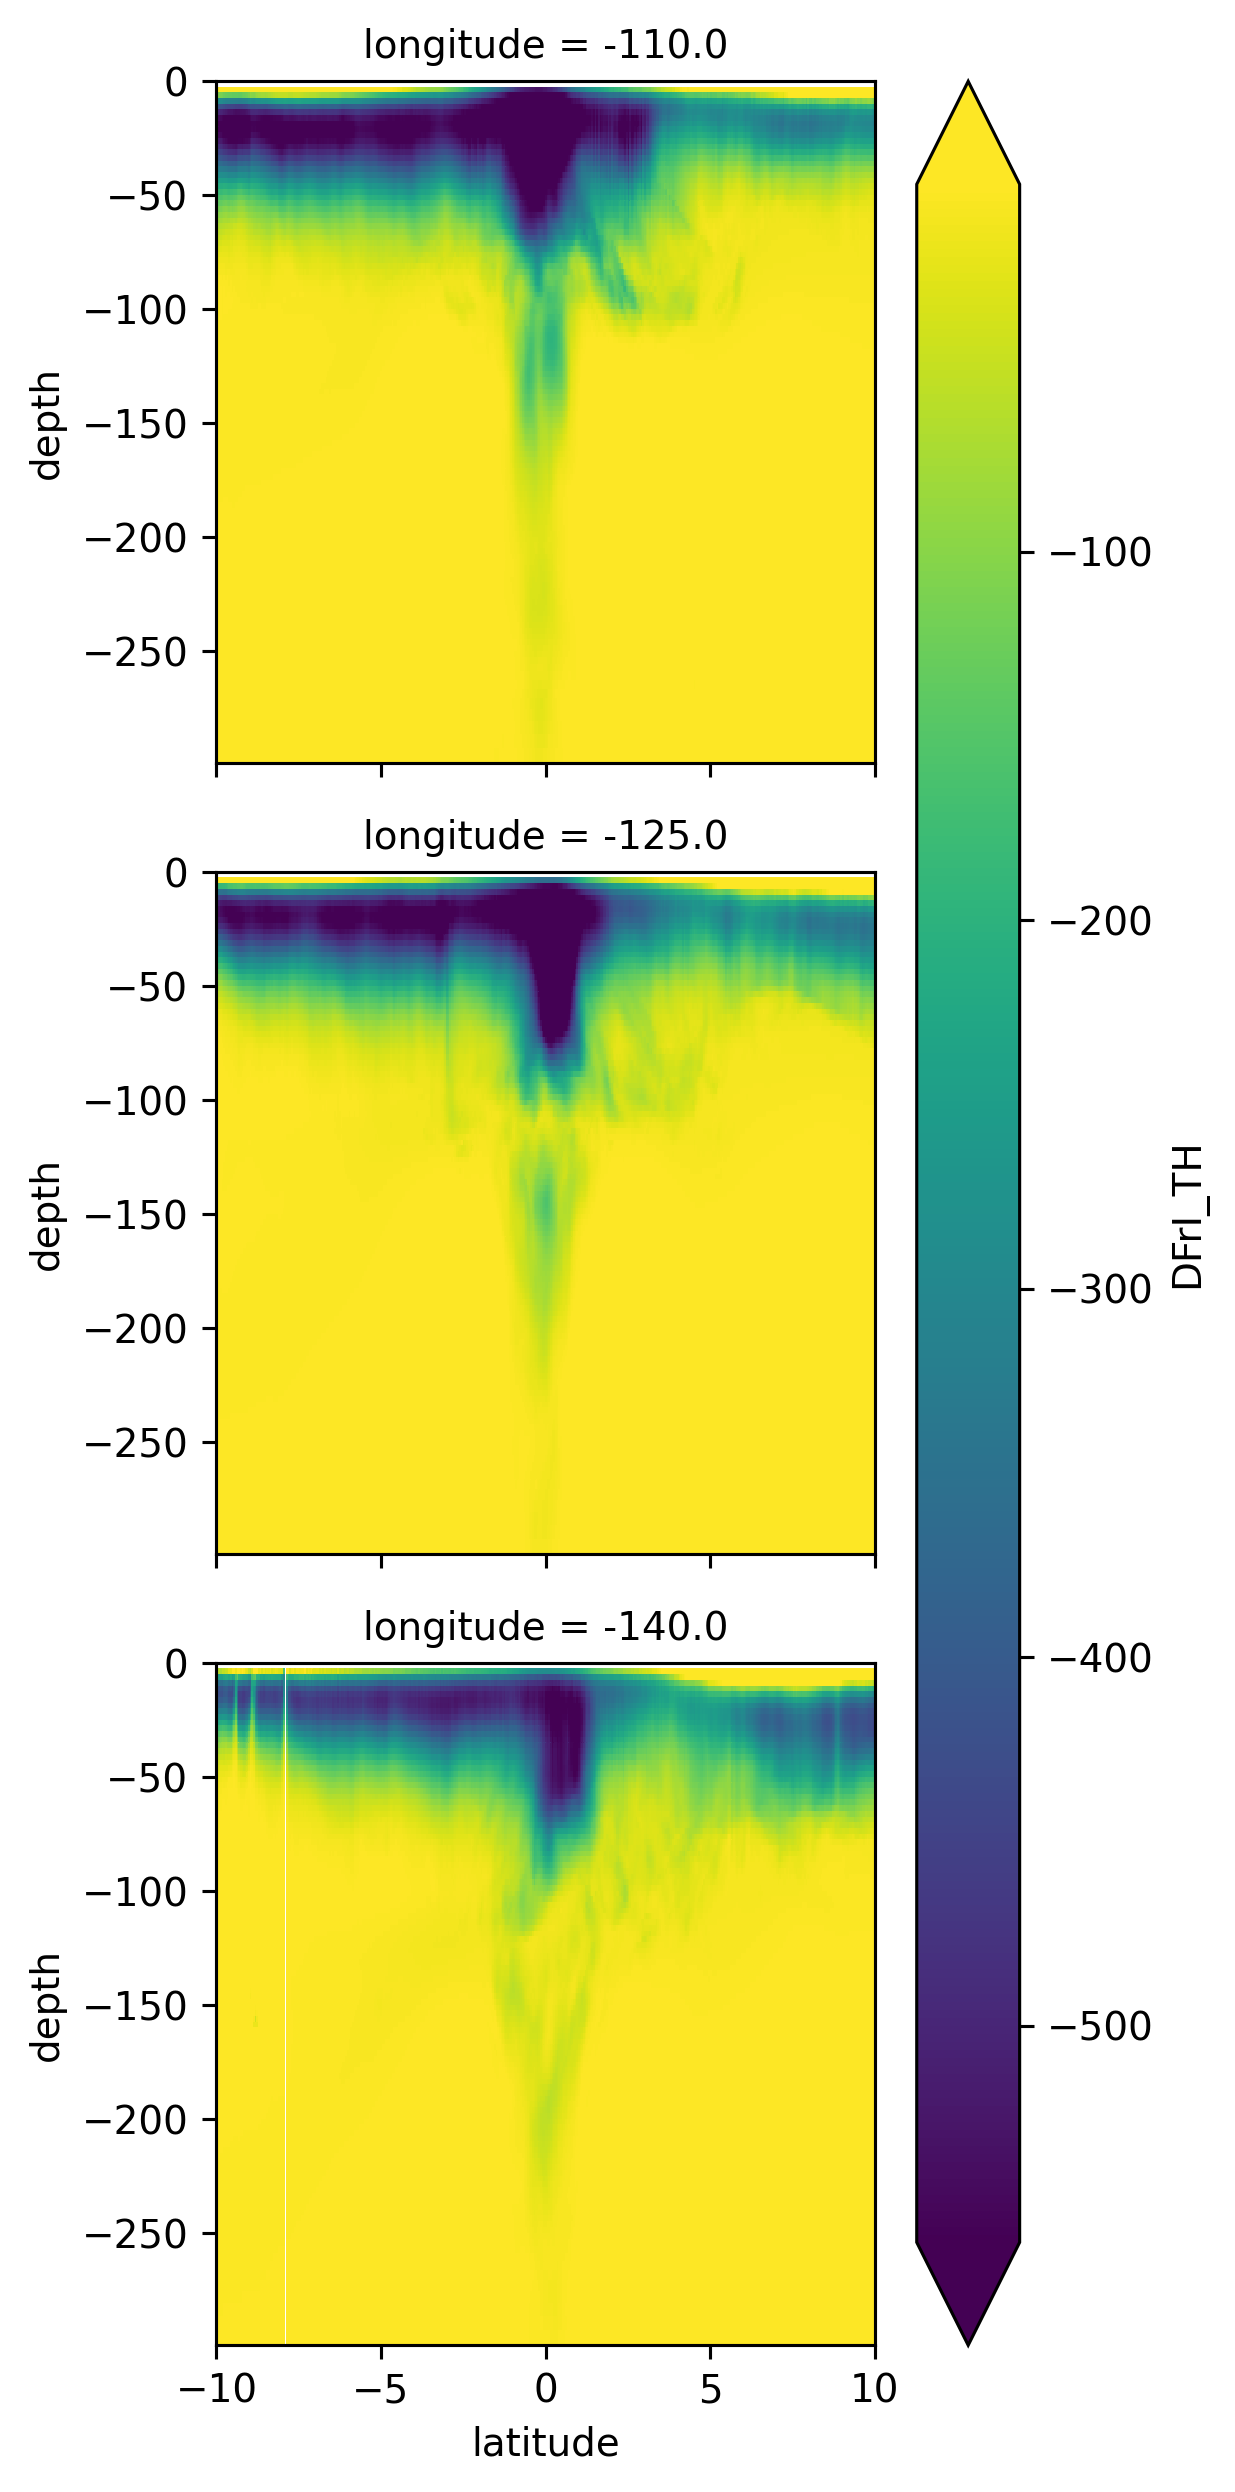

In [ ]:
mean_jq.plot(row="longitude", y="depth", robust=True)

### Stations

In [ ]:
metrics = pump.model.read_metrics(stationdirname)
stations = pump.model.read_stations_20(stationdirname)
enso = pump.obs.make_enso_mask()
stations["enso"] = enso.reindex(time=stations.time.data, method="nearest")

In [ ]:
sections = dcpy.dask.map_copy(
    stations.isel(latitude=slice(1, None, 3), longitude=slice(1, None, 3))
)
sections = pump.calc.calc_reduced_shear(sections)
sections["dcl_base"] = pump.calc.get_dcl_base_Ri(sections)

calc uz
calc vz
calc S2
calc N2
calc shred2
Calc Ri


In [ ]:
mld_dcl = xr.open_zarr(
    "/glade/work/dcherian/pump/zarrs/temp_mld_sections.zarr", consolidated=True
)
mld_dcl

<xarray.Dataset>
Dimensions:    (time: 174000, longitude: 4, latitude: 37)
Coordinates:
  * latitude   (latitude) float64 -3.025 -2.775 -2.525 ... 5.475 5.725 5.975
  * longitude  (longitude) float64 -155.0 -140.0 -125.0 -110.0
  * time       (time) datetime64[ns] 1998-12-31T18:00:00 ... 2018-11-06T17:00:00
Data variables:
    dcl_Jq     (time, longitude, latitude) float64 dask.array<chunksize=(6000, 1, 1), meta=np.ndarray>
    dcl_base   (time, longitude, latitude) float32 dask.array<chunksize=(21750, 1, 10), meta=np.ndarray>
    mld        (time, longitude, latitude) float32 dask.array<chunksize=(21750, 1, 10), meta=np.ndarray>
Attributes:
    easting:   longitude
    northing:  latitude
    title:     Station profile, index (i,j)=(1201,240)

In [ ]:
sections.update(mld_dcl)
sections = sections.cf.guess_coord_axis()

In [ ]:
sections["Jq"] = sections.Jq.persist()

## Exploring 2 box idealization



In [ ]:
moor = sections.sel(latitude=0, longitude=-140, method="nearest").sel(depth=slice(-500))

In [ ]:
moor = dcpy.dask.map_copy(moor)

In [ ]:
moor = moor.persist()

In [ ]:
moordaily = moor.resample(time="D").mean()

In [ ]:
moordaily["zeuc"] = pump.get_euc_max(moordaily.u)

In [ ]:
moordaily["zjmax"] = (
    moordaily.Jq.where(moordaily.depth > moordaily.zeuc).idxmin("depth").persist()
)

In [ ]:
moordaily["zwmax"] = moordaily.w.where(moordaily.depth > moordaily.zeuc).idxmax("depth")

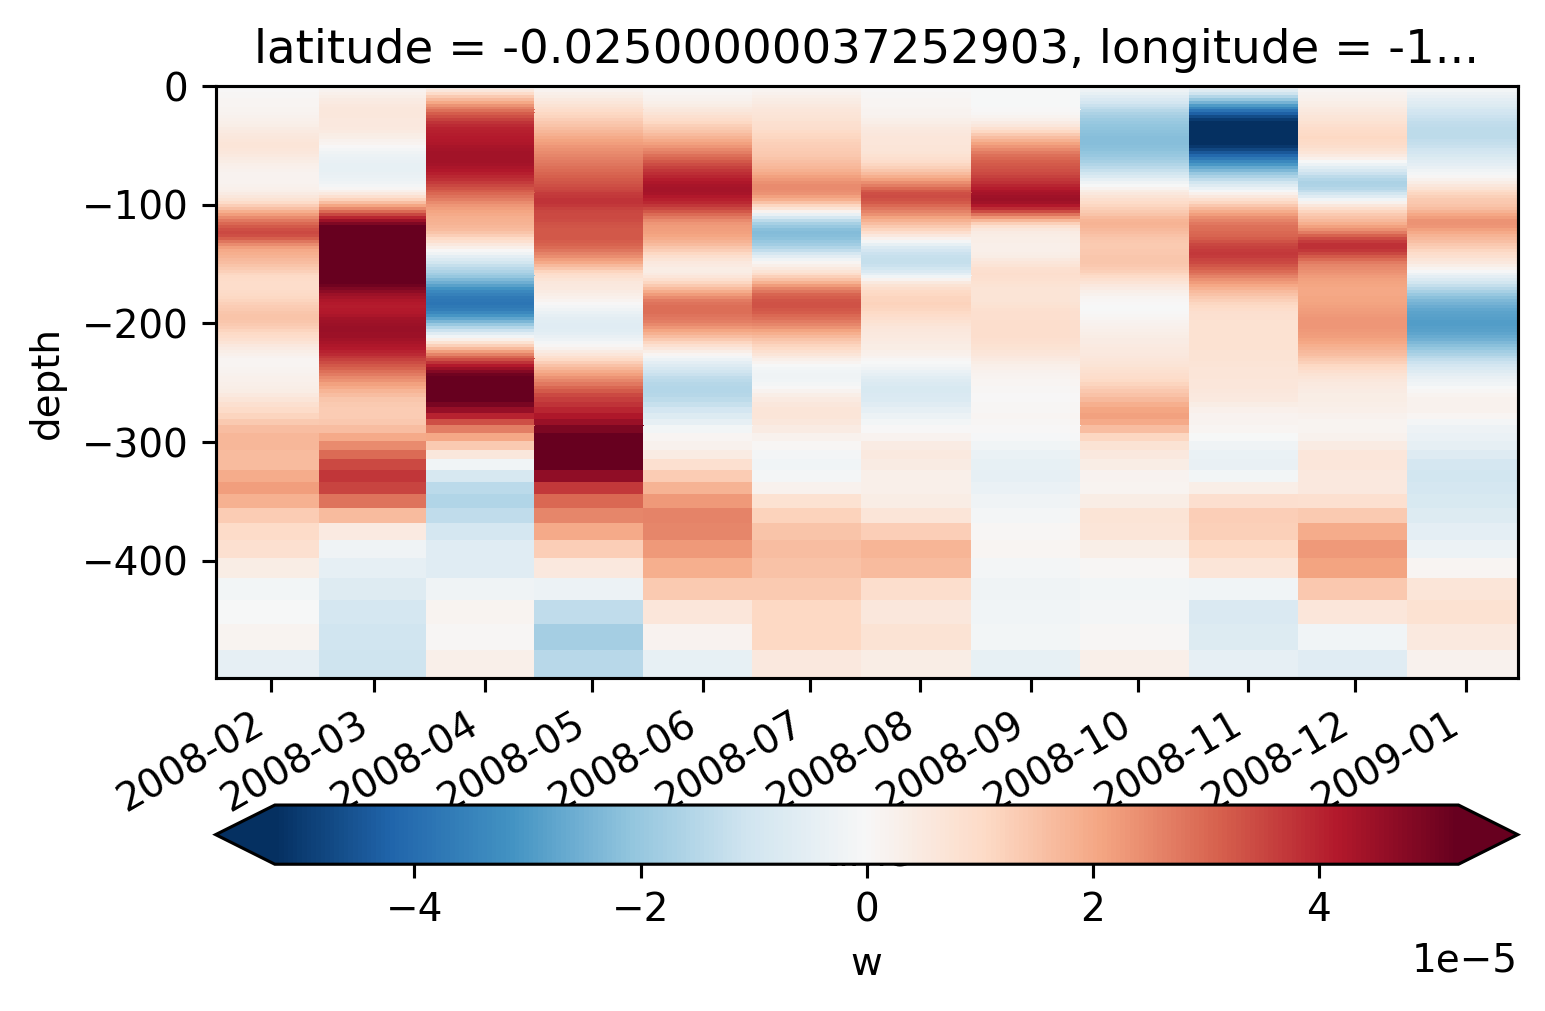

In [ ]:
moordaily.w.sel(time="2008").resample(time="M").mean().plot(
    x="time", robust=True, cbar_kwargs={"orientation": "horizontal"}
)

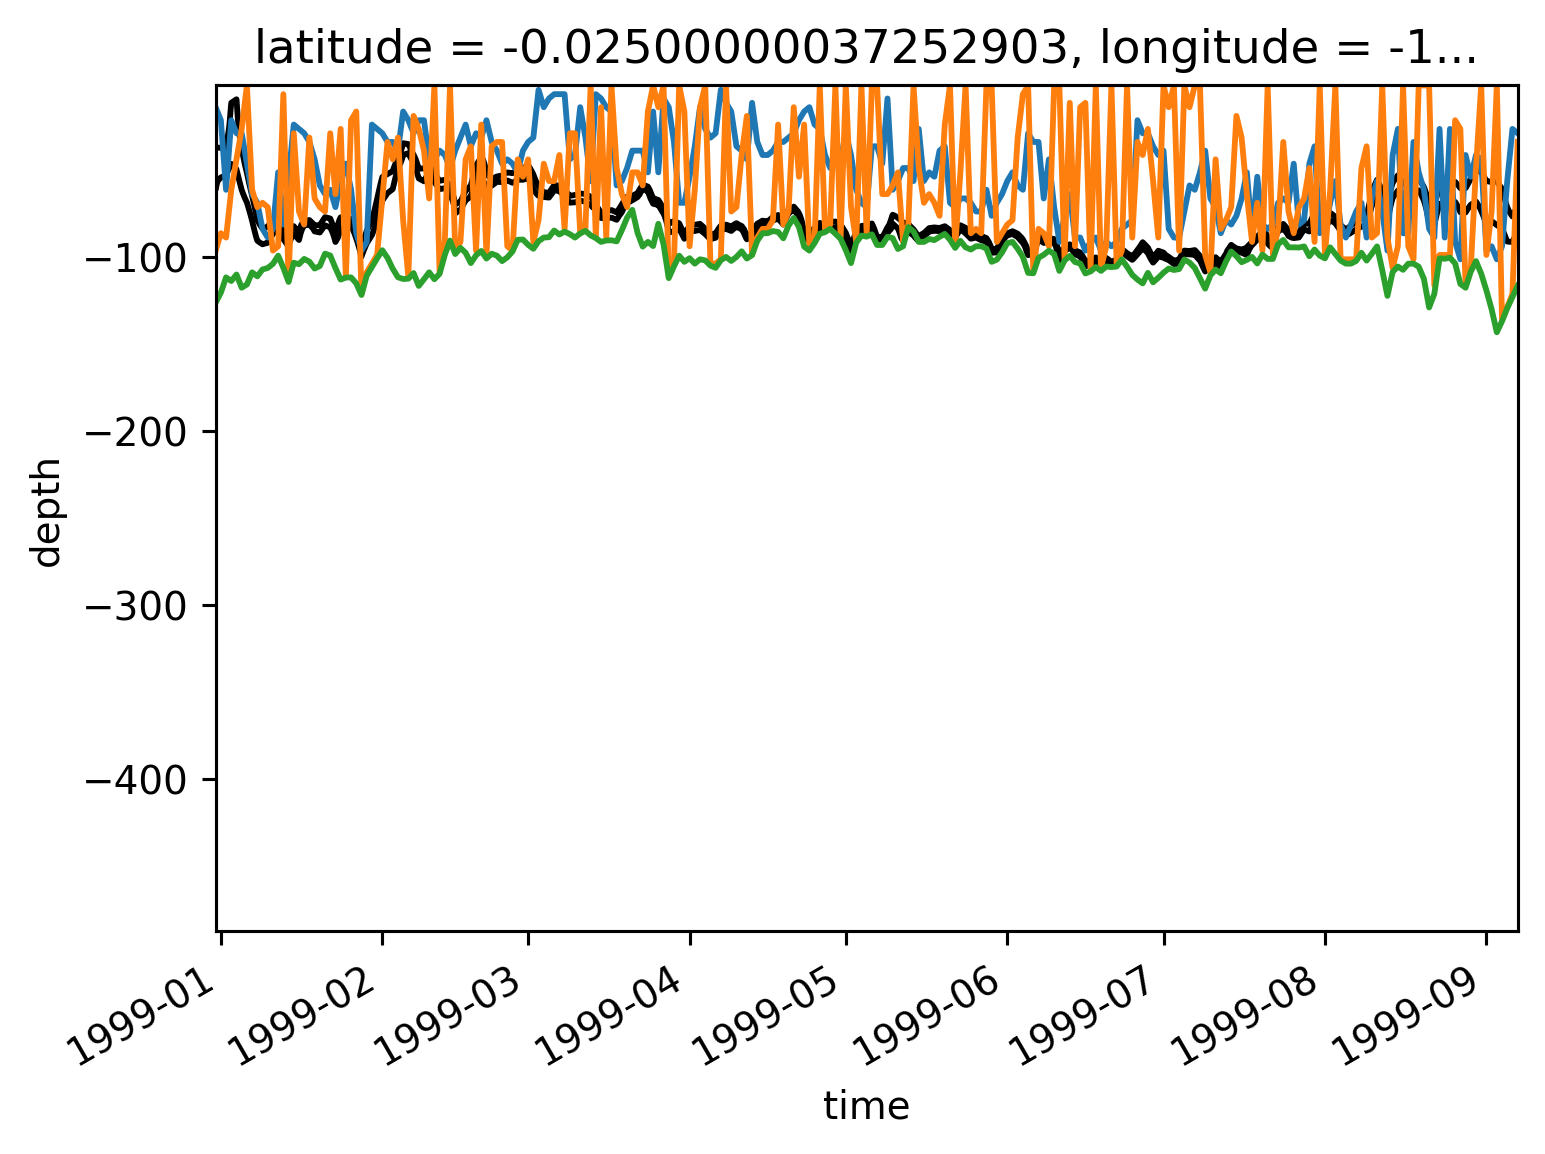

In [ ]:
moordaily.zjmax.plot(x="time")
moordaily.zwmax.plot(x="time")
moordaily.zeuc.plot(x="time")
moordaily.theta.plot.contour(x="time", levels=[21.5, 22], colors="k")

## DCL variation with ENSO phase

In [ ]:
sections["dcl"] = sections.mld - sections.dcl_base
sections["dcl_mask"] = (
    (sections.depth < sections.mld)
    & (sections.depth > sections.dcl_base)
    & (sections.dcl > 10)
)

sections["dcl_Jq"] = sections.Jq.where(sections.dcl_mask).sum("depth") / 30
sections

<xarray.Dataset>
Dimensions:        (depth: 185, latitude: 37, longitude: 4, time: 174000)
Coordinates:
  * depth          (depth) float32 -1.25 -3.75 -6.25 ... -5.658e+03 -5.758e+03
  * latitude       (latitude) float64 -3.025 -2.775 -2.525 ... 5.475 5.725 5.975
  * longitude      (longitude) float64 -155.0 -140.0 -125.0 -110.0
  * time           (time) datetime64[ns] 1998-12-31T18:00:00 ... 2018-11-06T1...
Data variables: (12/32)
    DFrI_TH        (depth, time, longitude, latitude) float32 dask.array<chunksize=(185, 6000, 1, 1), meta=np.ndarray>
    KPPdiffKzT     (depth, time, longitude, latitude) float32 dask.array<chunksize=(185, 6000, 1, 1), meta=np.ndarray>
    KPPg_TH        (depth, time, longitude, latitude) float32 dask.array<chunksize=(185, 6000, 1, 1), meta=np.ndarray>
    KPPhbl         (time, longitude, latitude) float32 dask.array<chunksize=(6000, 1, 1), meta=np.ndarray>
    KPPviscAz      (depth, time, longitude, latitude) float32 dask.array<chunksize=(185, 6000, 1, 1), meta=np.ndarray>
    SSH            (time, longitude, latitude) float32 dask.array<chunksize=(6000, 1, 1), meta=np.ndarray>
    ...             ...
    Ri             (depth, time, longitude, latitude) float64 dask.array<chunksize=(185, 6000, 1, 1), meta=np.ndarray>
    dcl_base       (time, longitude, latitude) float32 dask.array<chunksize=(21750, 1, 10), meta=np.ndarray>
    enso           (time) <U8 'La-Nina' 'La-Nina' ... 'Neutral' 'Neutral'
    dcl_Jq         (time, longitude, latitude) float64 dask.array<chunksize=(6000, 1, 1), meta=np.ndarray>
    dcl            (time, longitude, latitude) float32 dask.array<chunksize=(21750, 1, 10), meta=np.ndarray>
    dcl_mask       (depth, time, longitude, latitude) bool dask.array<chunksize=(185, 21750, 1, 10), meta=np.ndarray>
Attributes:
    easting:   longitude
    northing:  latitude
    title:     Station profile, index (i,j)=(1201,240)

At least 10m DCL; at each hour, mean $J_q$ in deep cycle layer is calcualted as $1/(30m)∫ J_q dz$ integrated in depth between $z_{MLD}$ and $z_{Ri}$ assuming a mean deep-cycle layer width of 30m

In [ ]:
plt.style.use("ggplot")

In [ ]:
enso_mean_Jq = sections.dcl_Jq.groupby(sections.enso).mean().compute()

At least 10m DCL width

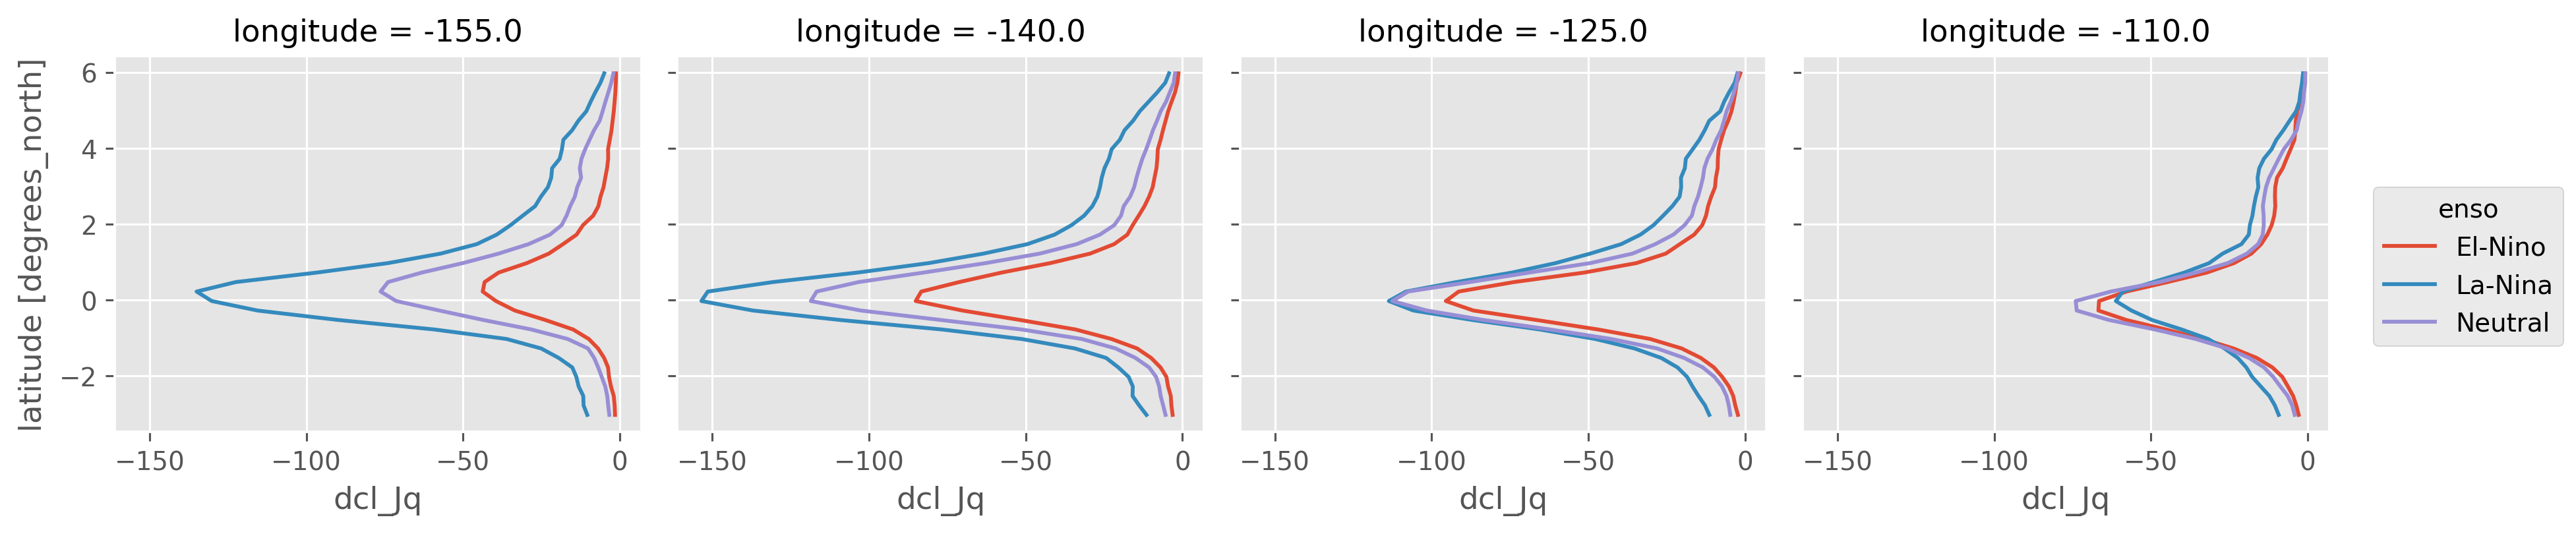

In [ ]:
enso_mean_Jq.plot(hue="enso", col="longitude", y="latitude")

In [ ]:
enso_sum_Jq = sections.dcl_Jq.groupby(sections.enso).sum().compute()

In [ ]:
enso_count_Jq = sections.dcl_Jq.groupby(sections.enso).count().compute()

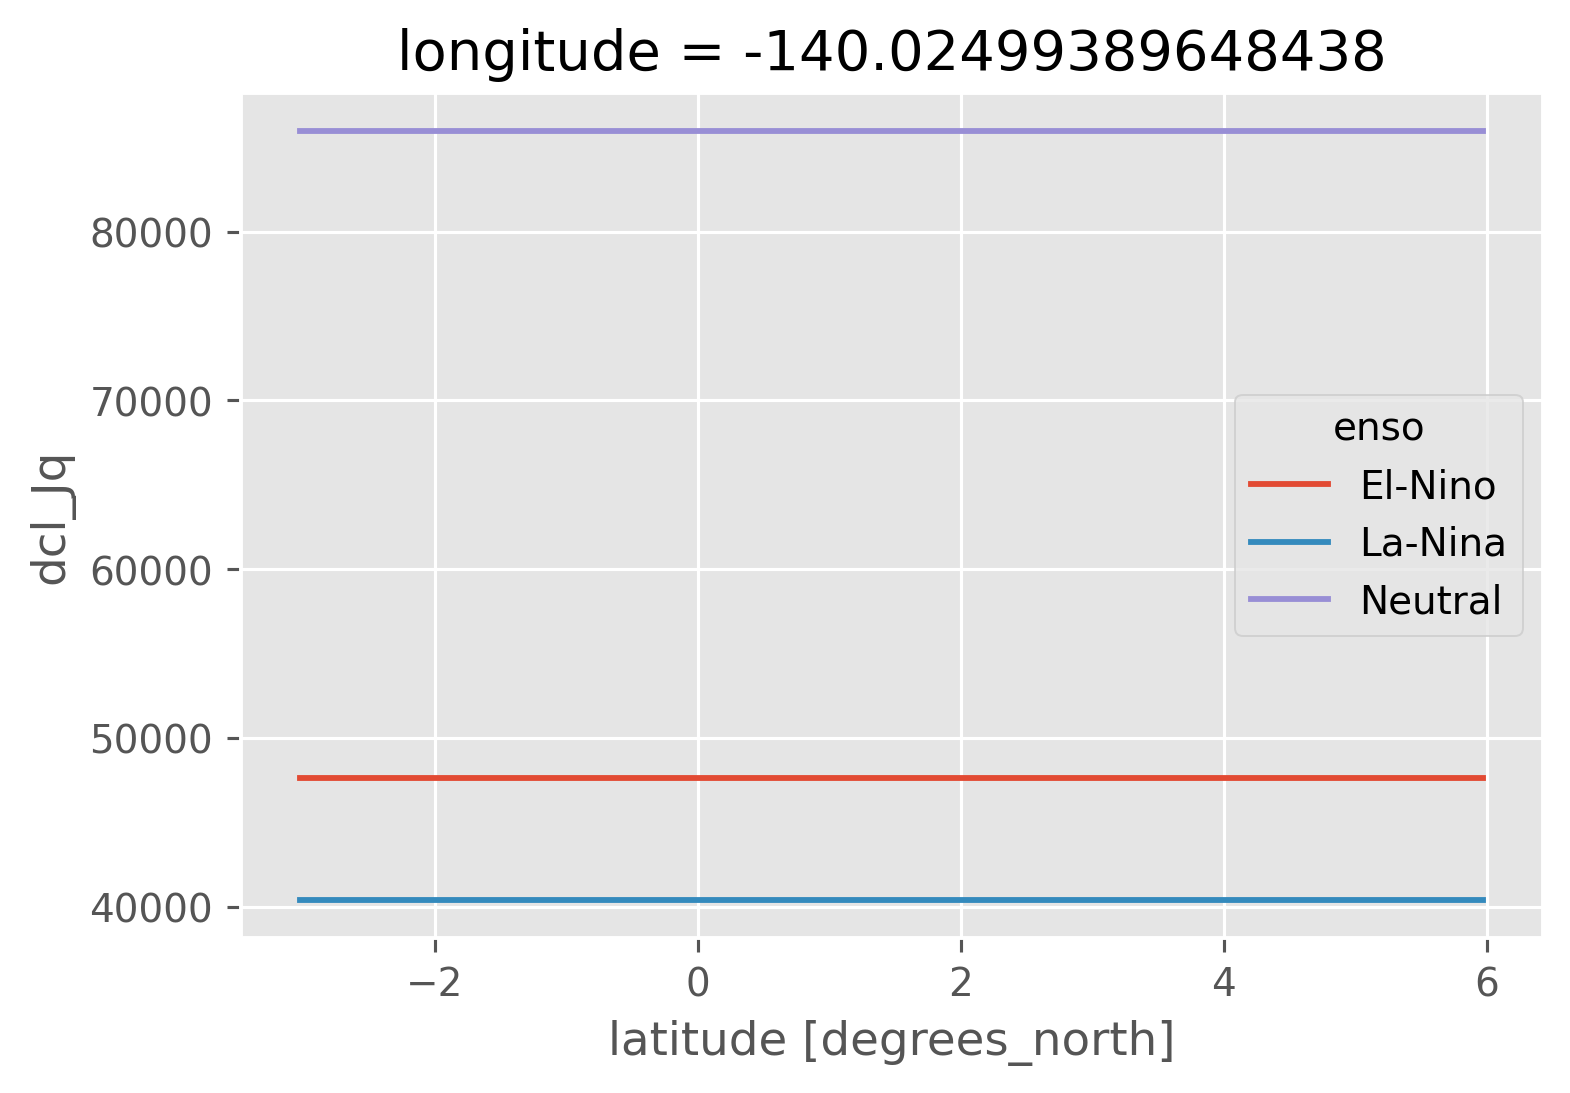

In [ ]:
enso_count_Jq.sel(longitude=-140, method="nearest").plot(hue="enso")

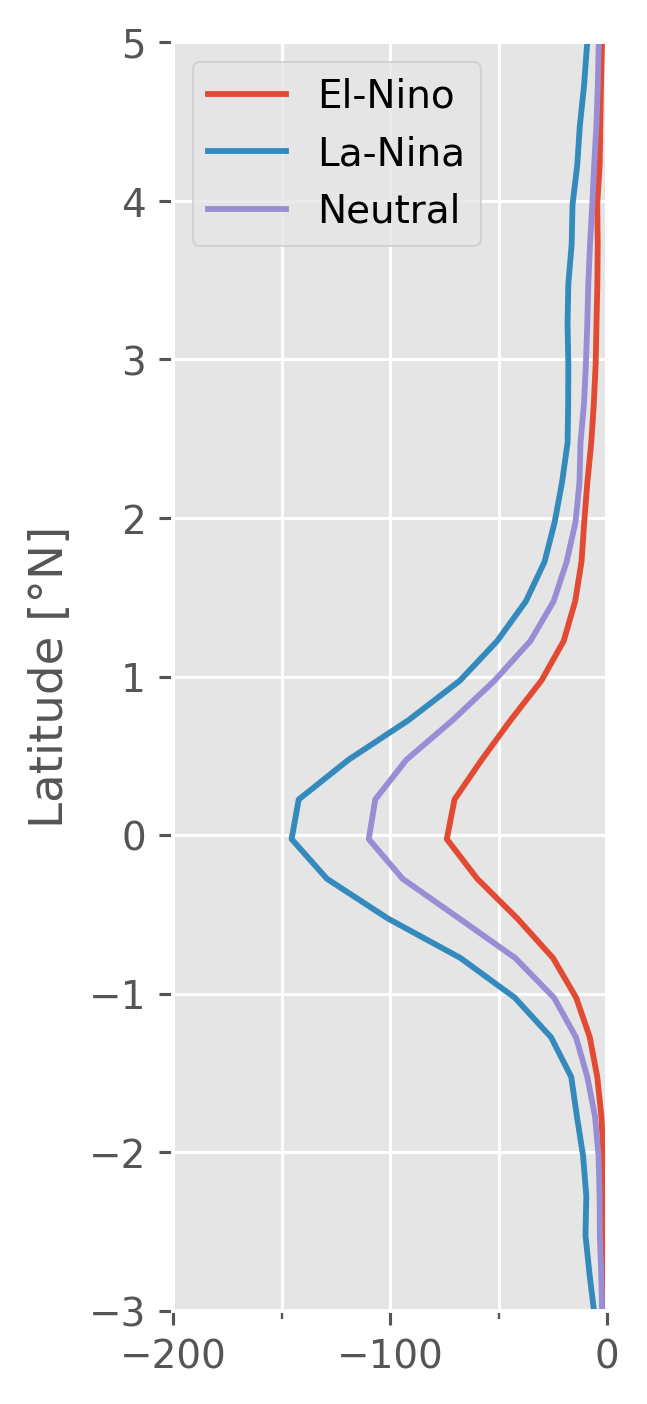

In [ ]:
(enso_mean_Jq.sel(longitude=-140, method="nearest")).plot(
    y="latitude", hue="enso", size=4, aspect=1, ylim=(-3, 5)
)
ax = plt.gca()
ax.get_legend().set_title("")
ax.set_xlabel("")
ax.set_ylabel("Latitude [°N]")
ax.set_title("140°W")
ax.set_xlim([-200, 0])
plt.gcf().set_size_inches((2, 6))

for aa in [ax]:
    aa.set_title("")
    aa.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    aa.grid(True, which="both")
    aa.set_ylim((-3, 5))

At least 30m DCL

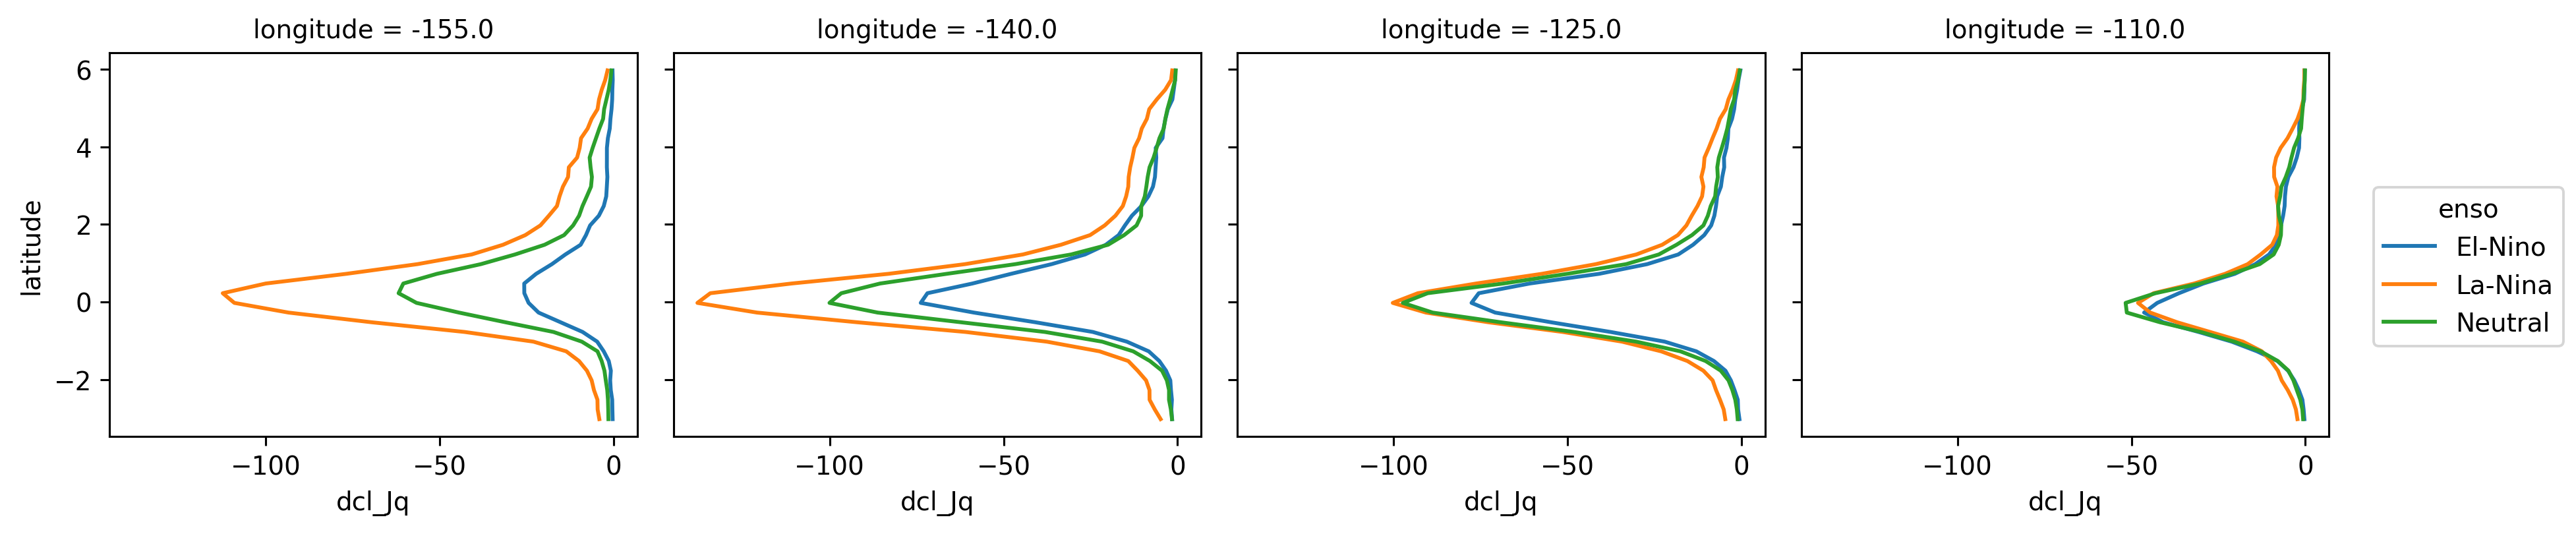

In [ ]:
sections.dcl_Jq.groupby(sections.enso).mean().plot(
    hue="enso", col="longitude", y="latitude"
)

## DCL width histograms

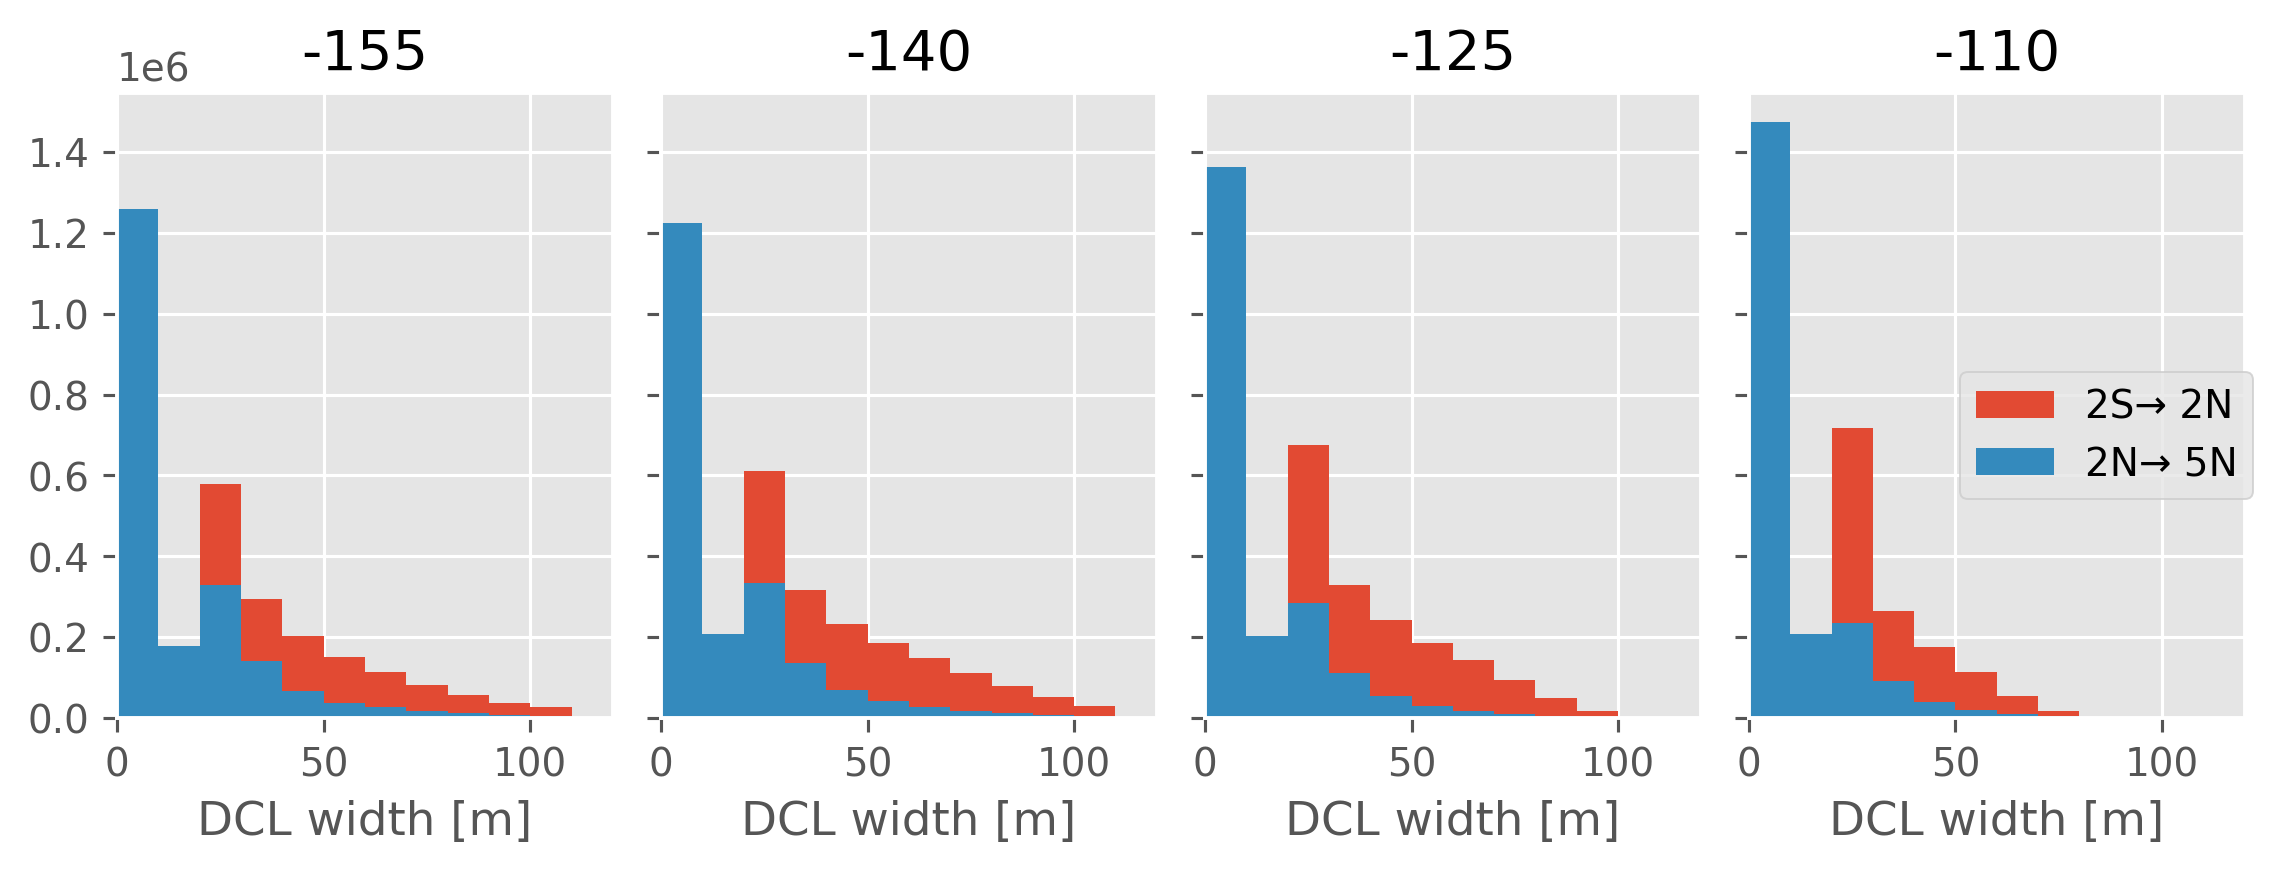

In [ ]:
sections.dcl.attrs["long_name"] = "DCL width"
hdl = [None, None]
f, axx = plt.subplots(1, 4, sharex=True, sharey=True, constrained_layout=True)
for lon, ax in zip([-155, -140, -125, -110], axx):
    kwargs = dict(ax=ax, bins=range(0, 111, 10), histtype="bar")
    hdl[0] = (
        sections.dcl.sel(longitude=lon, method="nearest")
        .sel(latitude=slice(-2, 2))
        .plot.hist(**kwargs)[2]
    )
    hdl[1] = (
        sections.dcl.sel(longitude=lon, method="nearest")
        .sel(latitude=slice(2, 5))
        .plot.hist(**kwargs)[2]
    )
    ax.set_title(f"{lon}")
    ax.set_xlim([0, 120])
f.legend(handles=hdl, labels=["2S→ 2N", "2N→ 5N"], loc="right")
f.set_size_inches((8, 3))

In [ ]:
sections.v.sel(latitude=0, method="nearest").sel(depth=slice(-80, 0))

<xarray.DataArray 'v' (depth: 0, time: 174000, longitude: 4)>
dask.array<getitem, shape=(0, 174000, 4), dtype=float32, chunksize=(0, 6000, 1), chunktype=numpy.ndarray>
Coordinates:
  * depth      (depth) float32 
    latitude   float64 -0.025
  * longitude  (longitude) float64 -155.0 -140.0 -125.0 -110.0
  * time       (time) datetime64[ns] 1998-12-31T18:00:00 ... 2018-11-06T17:00:00

In [ ]:
def calc_tiw_ke(v, interp_gaps=False):
    import xfilter

    vmean = v.sel(depth=slice(0, -80)).mean("depth")

    if interp_gaps:
        vmean = vmean.chunk({"time": -1}).interpolate_na("time", max_gap="10D")
    # Moum et al. 2009 metric
    v = xfilter.bandpass(
        vmean.compute(),
        "time",
        freq=[1 / 12, 1 / 33],
        cycles_per="D",
        debug=False,
        num_discard=120,
    )
    tiwke = xfilter.lowpass(
        v**2 / 2,
        "time",
        freq=1 / 20,
        cycles_per="D",
    )
    tiwke.attrs = {"long_name": "TIW KE", "units": "m²/s²"}
    return tiwke


tiwke = calc_tiw_ke(sections.v.sel(latitude=0, method="nearest"))

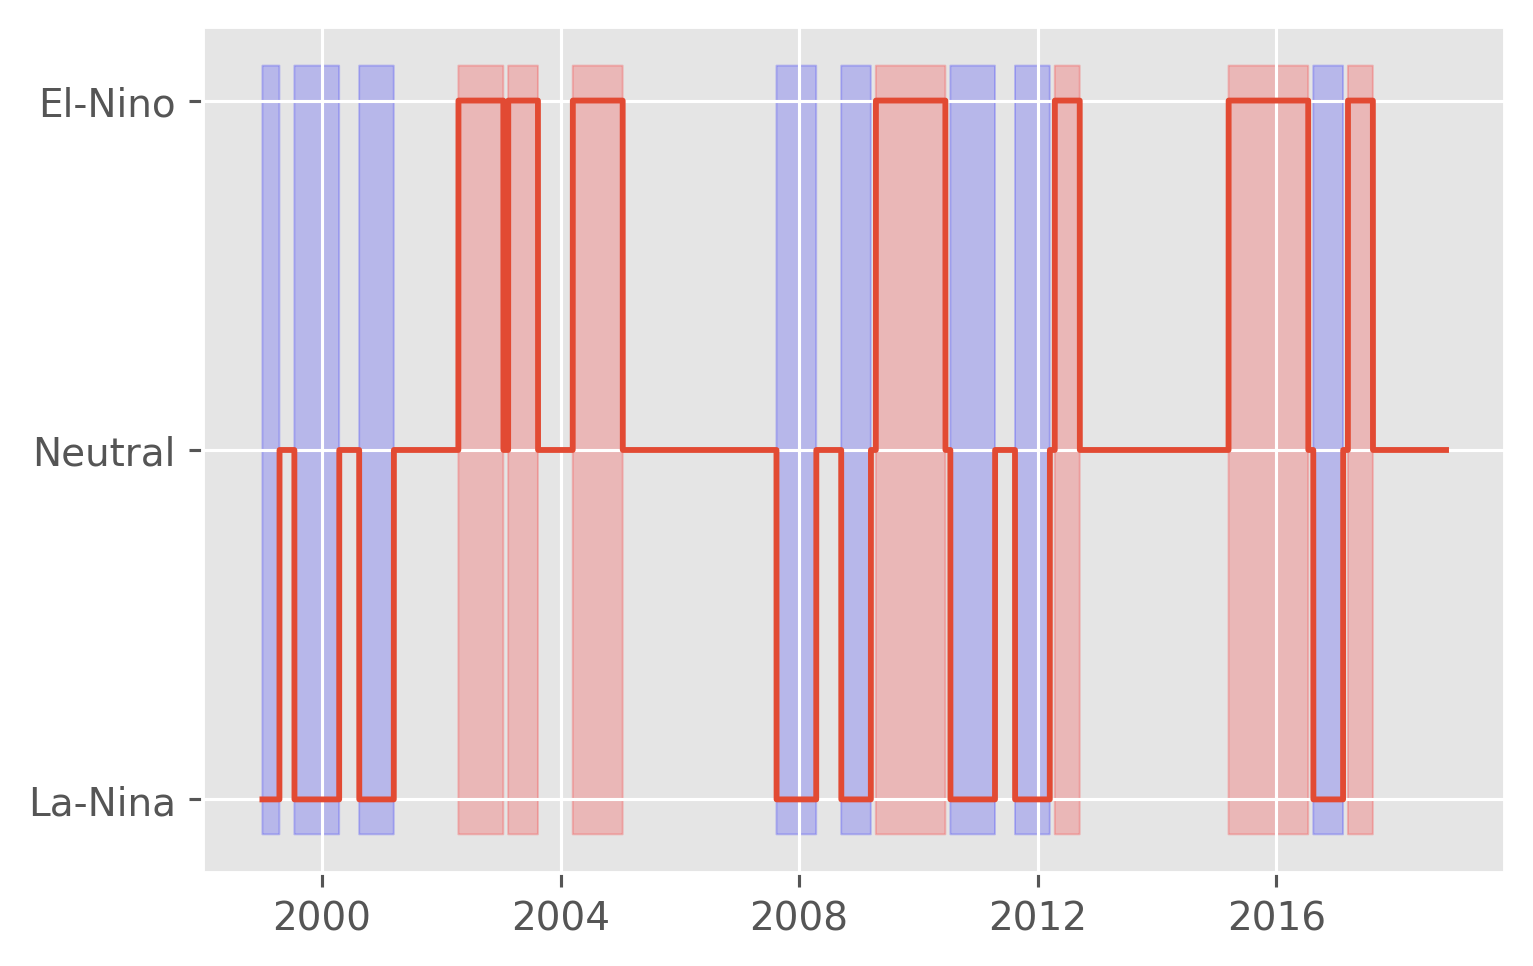

In [ ]:
plt.plot(sections.time, sections.enso)
pump.plot.highlight_enso(plt.gca(), sections.enso)

## Check ENSO definition vs TIWKE

[None, None, None, None]

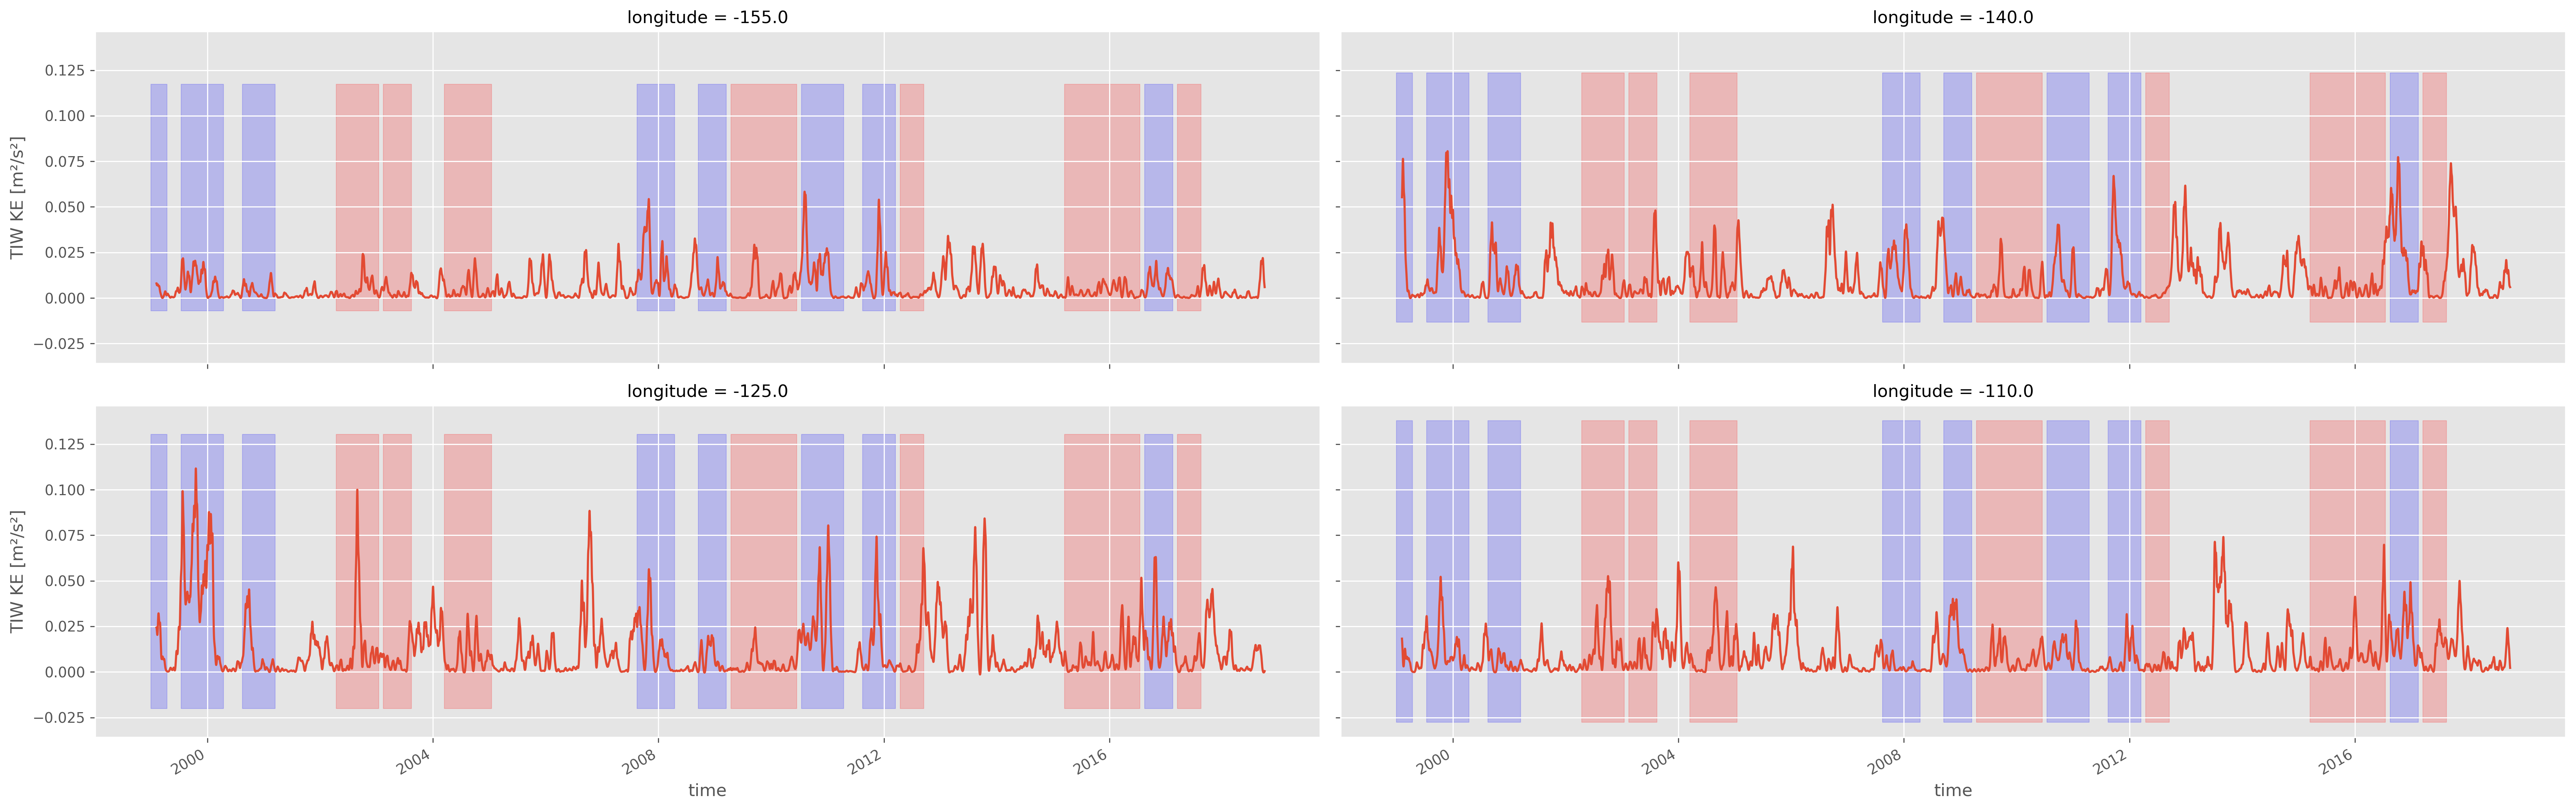

In [ ]:
fg = tiwke.plot(col="longitude", size=4, aspect=3, col_wrap=2)
[pump.plot.highlight_enso(ax, sections.enso) for ax in fg.axes.flat]

# Lat binned Jq_dcl with enso phase, TIW KE

In [ ]:
lat_binned_Jq = sections.dcl_Jq.groupby_bins("latitude", (-2, 2, 5)).mean().compute()

[None, None, None, None]

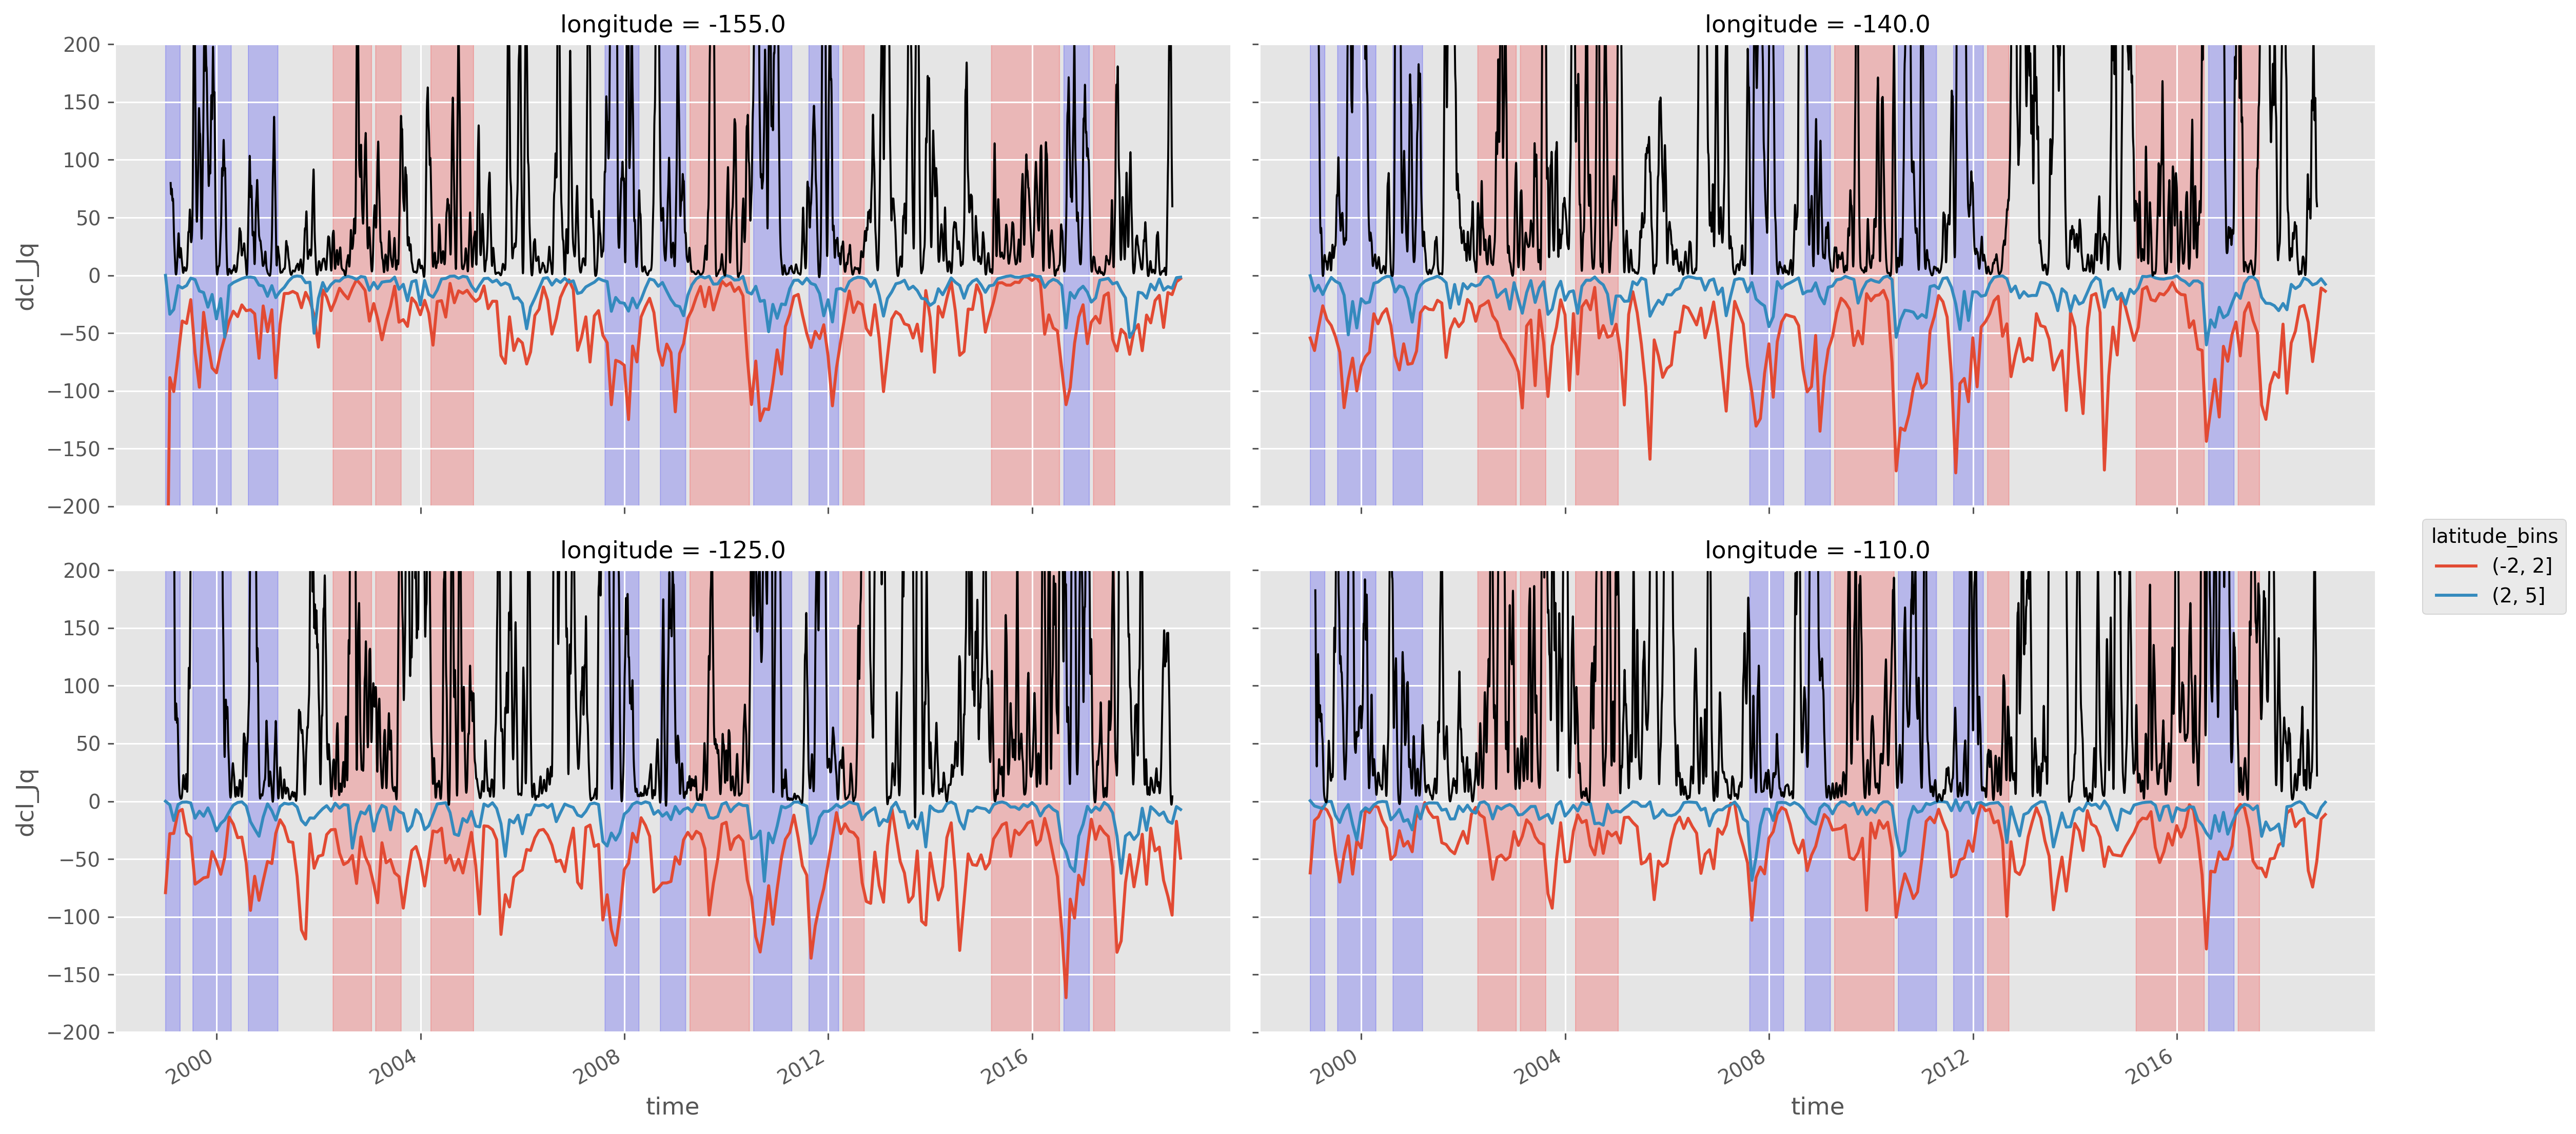

In [ ]:
fg = (
    lat_binned_Jq.resample(time="M")
    .mean()
    .plot(
        hue="latitude_bins",
        col="longitude",
        col_wrap=2,
        size=4,
        aspect=2,
        ylim=(-200, 200),
    )
)
for ax, loc in zip(fg.axes.flat, fg.name_dicts.flat):
    (1e4 * tiwke).sel(loc).plot(x="time", ax=ax, color="k", _labels=False, lw=1)
[pump.plot.highlight_enso(ax, sections.enso) for ax in fg.axes.flat]

## Debug metric with period4 TIW

inconclusive AFAIR

In [ ]:
# period4 = xr.open_dataset("/glade/scratch/dcherian/TPOS_MITgcm_1_hb/110w-period-4-with-jq.nc")

period4 = xr.open_zarr(
    "/glade/work/dcherian/pump/zarrs/110w-period-4-4.zarr", consolidated=True
).chunk({"time": 50})
period4

<xarray.Dataset>
Dimensions:    (depth: 200, latitude: 400, longitude: 3, time: 779)
Coordinates:
  * depth      (depth) float32 -0.5 -1.5 -2.5 -3.5 ... -197.5 -198.5 -199.5
  * latitude   (latitude) float32 -10.0 -9.95 -9.9 -9.85 ... 9.85 9.9 9.95 10.0
  * longitude  (longitude) float32 -110.1 -110.0 -110.0
  * time       (time) datetime64[ns] 1995-11-14T17:00:00 ... 1995-12-17T03:00:00
Data variables:
    DFrI_TH    (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    ETAN       (time, latitude, longitude) float32 dask.array<chunksize=(50, 400, 3), meta=np.ndarray>
    Jq         (time, depth, latitude, longitude) float64 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    KPPRi      (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    KPPbo      (time, latitude, longitude) float32 dask.array<chunksize=(50, 400, 3), meta=np.ndarray>
    KPPdiffT   (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    KPPg_TH    (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    KPPhbl     (time, latitude, longitude) float32 dask.array<chunksize=(50, 400, 3), meta=np.ndarray>
    KPPviscA   (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    N2         (time, depth, latitude, longitude) float64 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    Ri         (time, depth, latitude, longitude) float64 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    S2         (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    Um_Diss    (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    VISrI_Um   (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    VISrI_Vm   (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    Vm_Diss    (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    dcl        (time, latitude, longitude) float32 dask.array<chunksize=(50, 400, 3), meta=np.ndarray>
    dcl_base   (time, latitude, longitude) float32 dask.array<chunksize=(50, 400, 3), meta=np.ndarray>
    dens       (time, depth, latitude, longitude) float64 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    eucmax     (time, longitude) float64 dask.array<chunksize=(50, 3), meta=np.ndarray>
    mld        (time, latitude, longitude) float32 dask.array<chunksize=(50, 400, 3), meta=np.ndarray>
    salt       (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    shear      (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    shred2     (time, depth, latitude, longitude) float64 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(50, 400, 3), meta=np.ndarray>
    theta      (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    u          (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    uz         (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    v          (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    vz         (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
    w          (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 200, 400, 3), meta=np.ndarray>
Attributes:
    easting:            longitude
    field_julian_date:  400296
    julian_day_unit:    days since 1950-01-01 00:00:00
    nor

### Heat flux & divergence

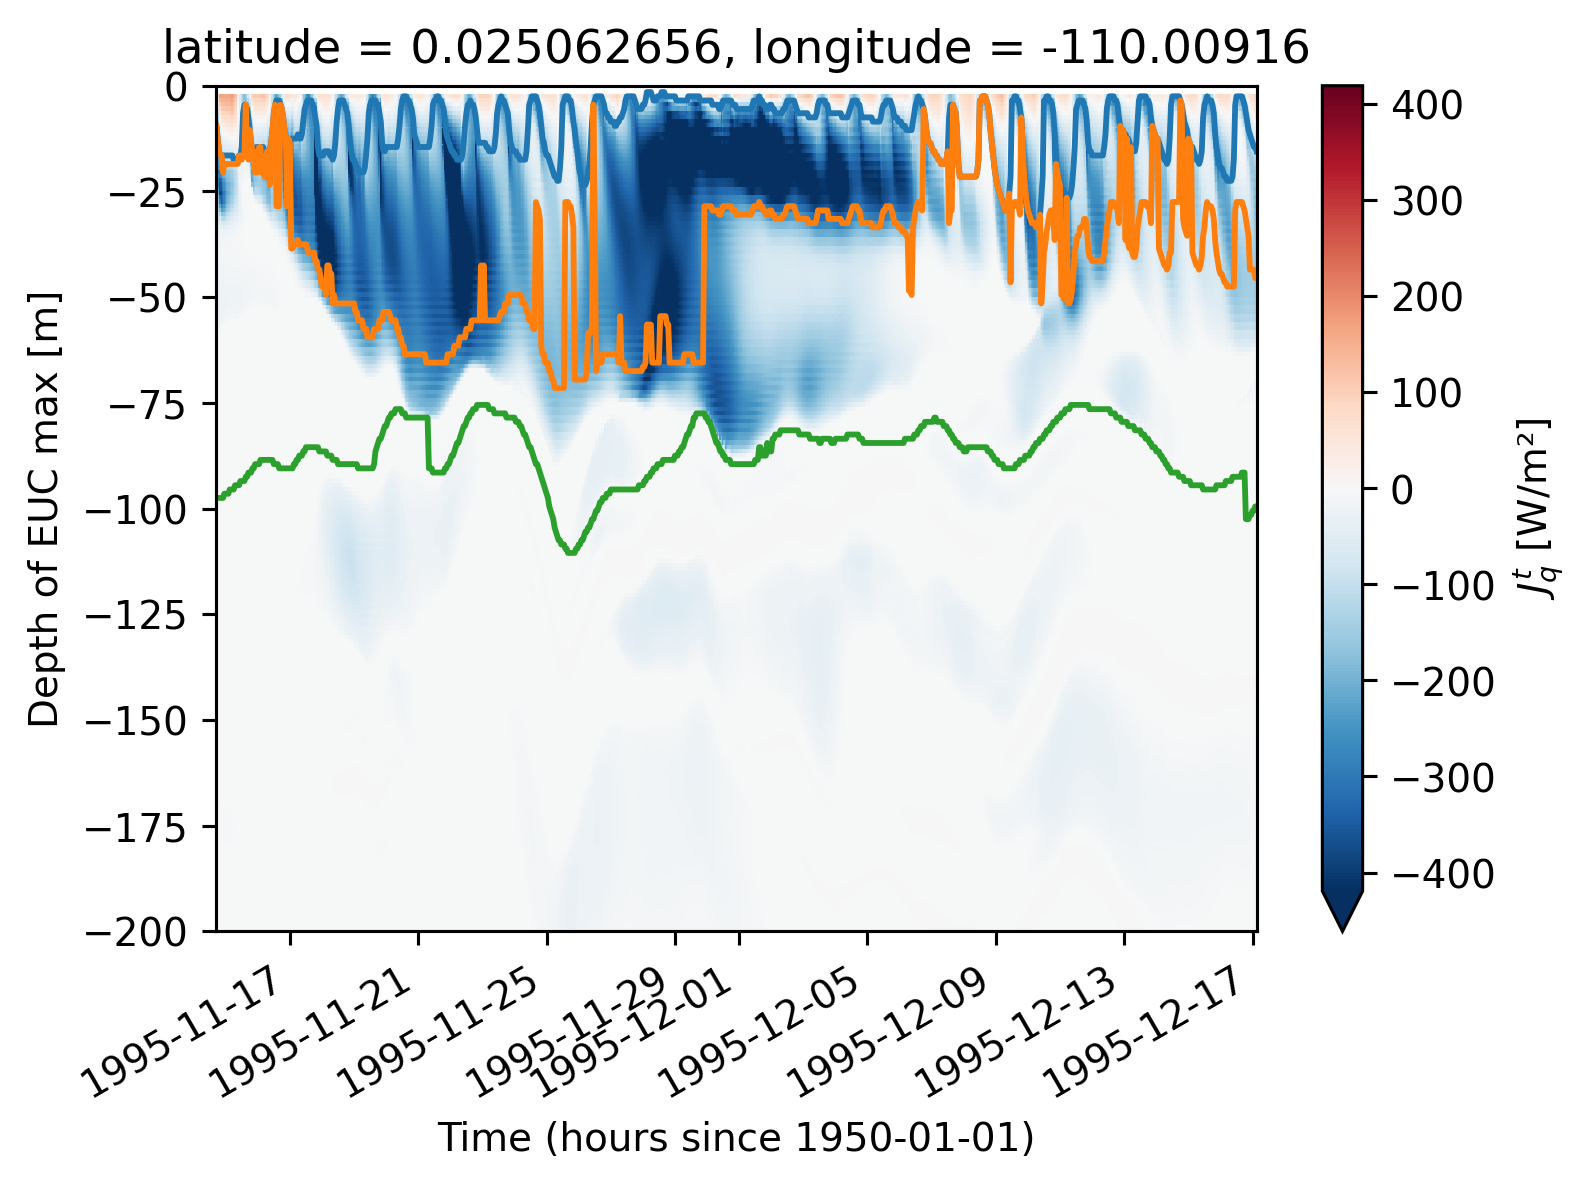

In [ ]:
subset = period4.isel(longitude=1).sel(latitude=0, method="nearest")

(subset.Jq.rolling(depth=2).mean().compute()).plot(x="time", robust=True)
subset.mld.plot()
subset.dcl_base.plot()
subset.eucmax.plot()

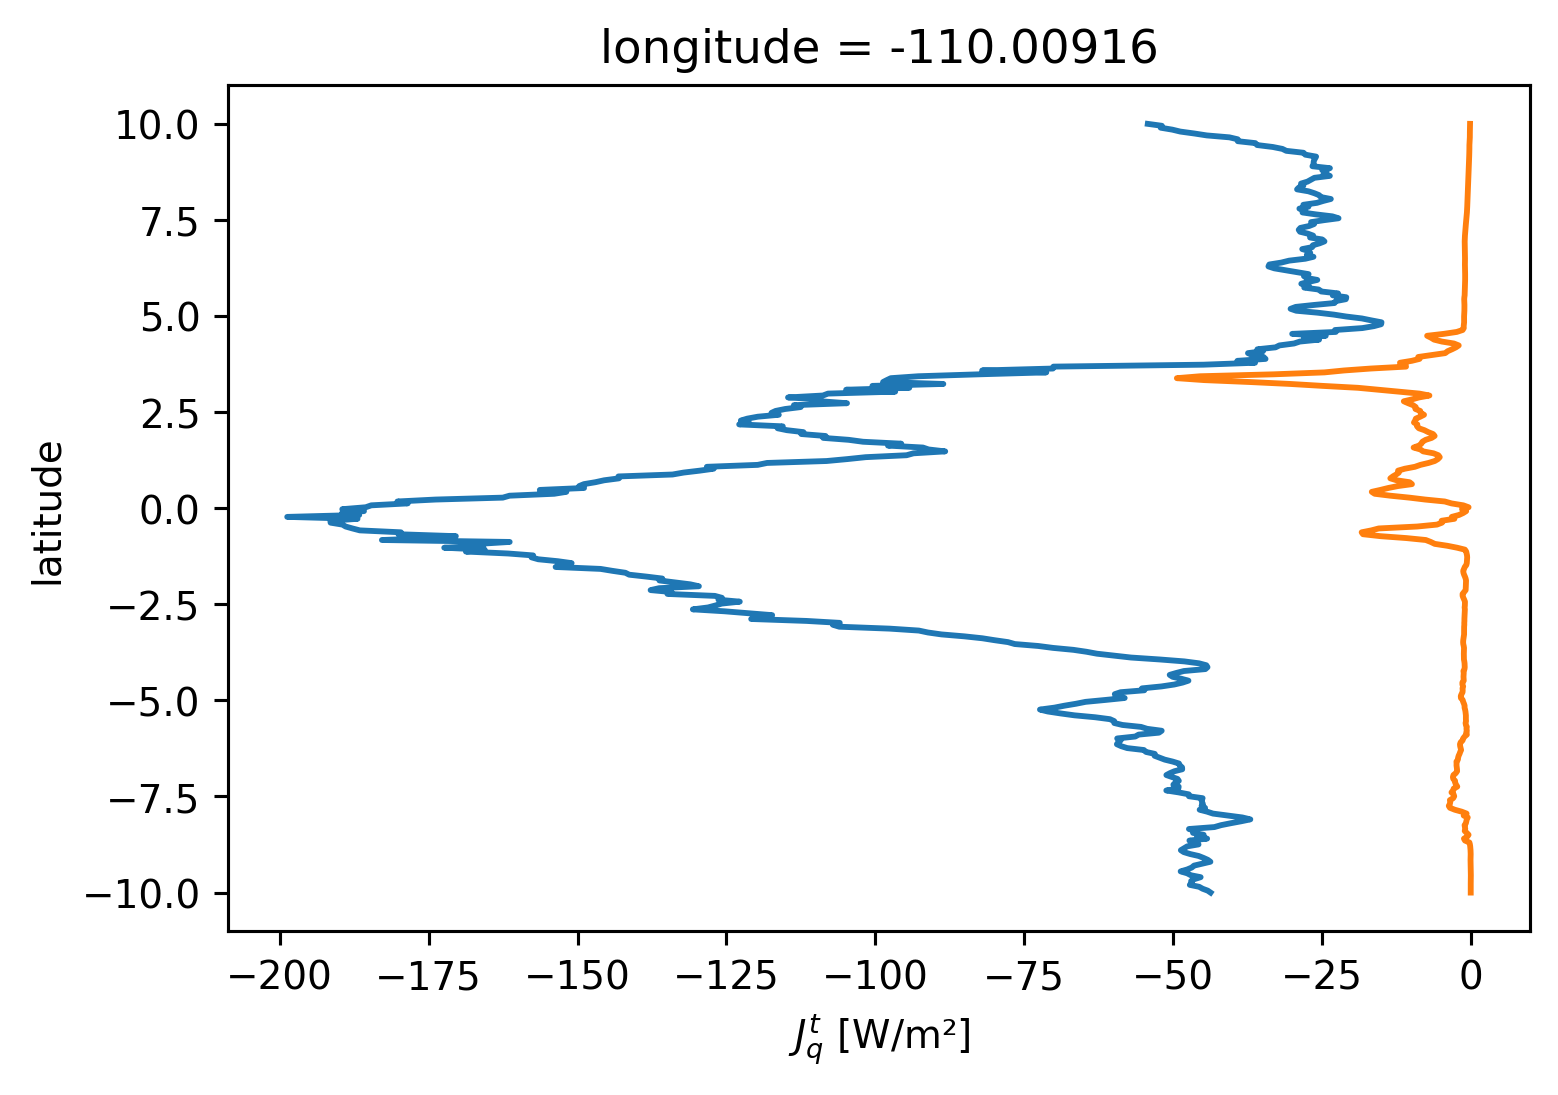

In [ ]:
subset = period4.isel(longitude=1)
subset.Jq.sel(depth=subset.mld).mean("time").plot(y="latitude")
subset.Jq.sel(depth=subset.eucmax).mean("time").plot(y="latitude")

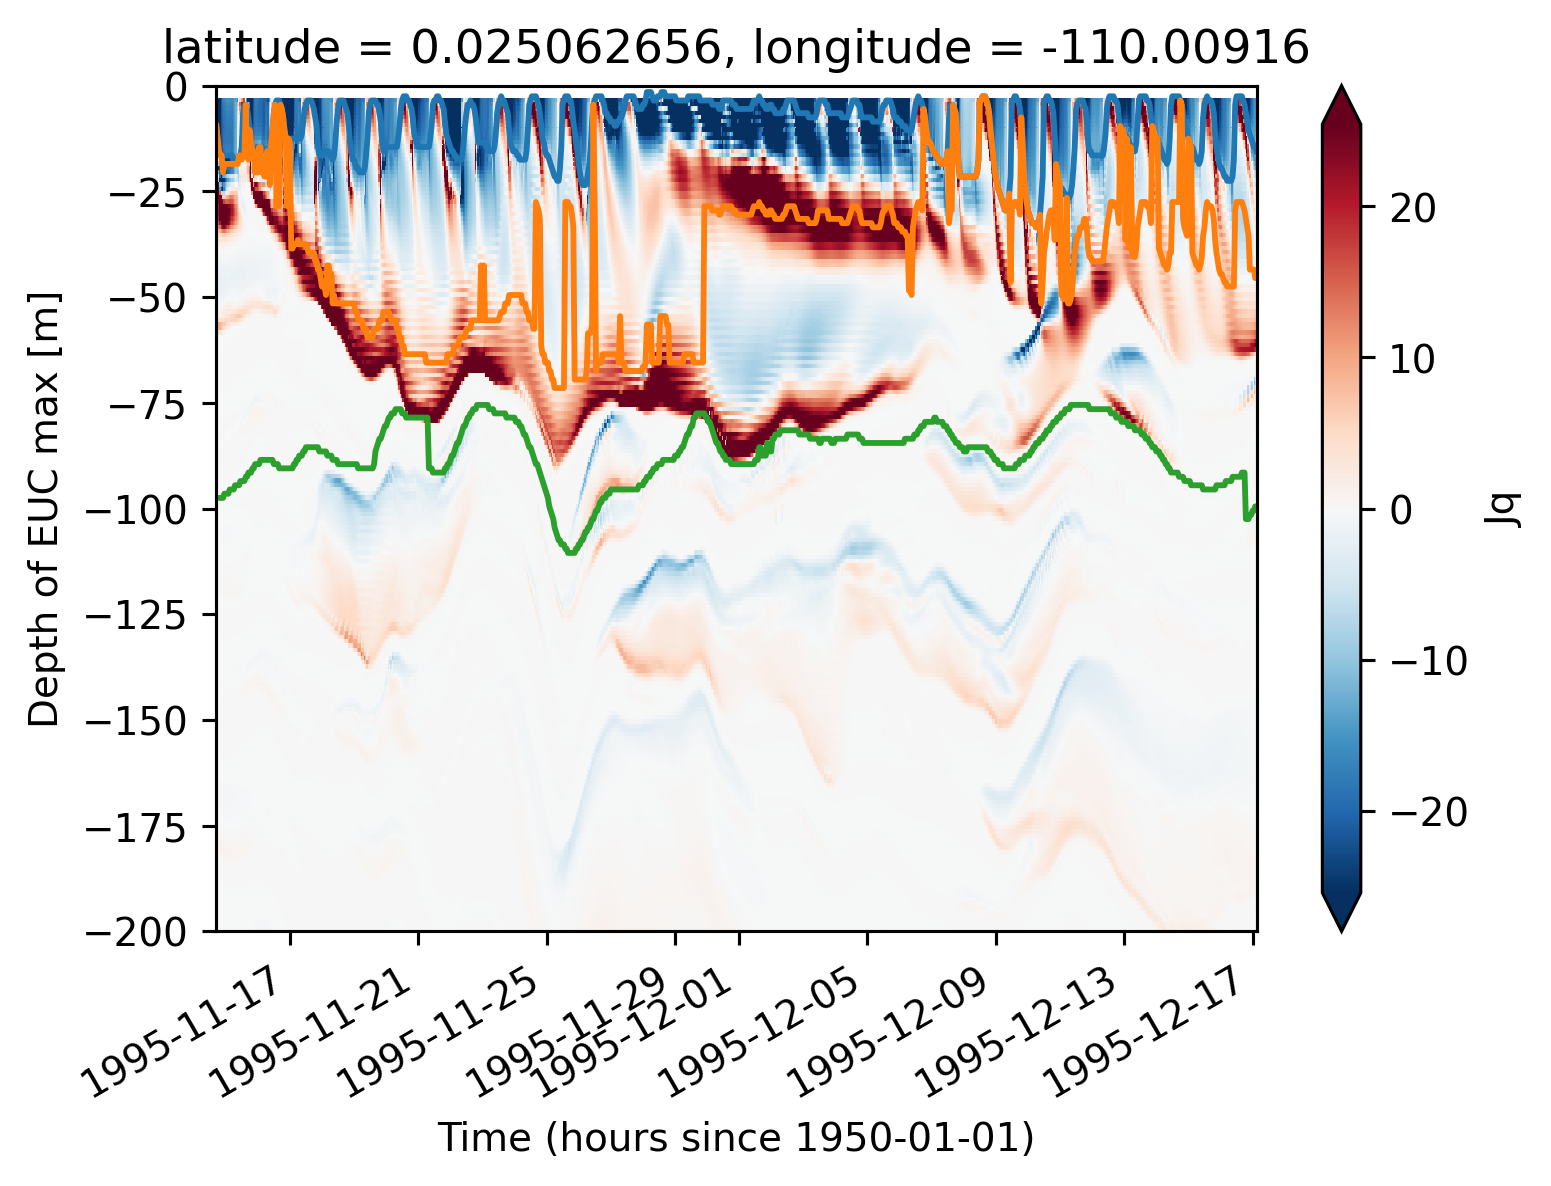

In [ ]:
subset = period4.isel(longitude=1).sel(latitude=0, method="nearest")

dJdz = -1 * subset.Jq.rolling(depth=2).mean().compute().differentiate("depth")

dJdz.plot(x="time", robust=True)
subset.mld.plot()
subset.dcl_base.plot()
subset.eucmax.plot()

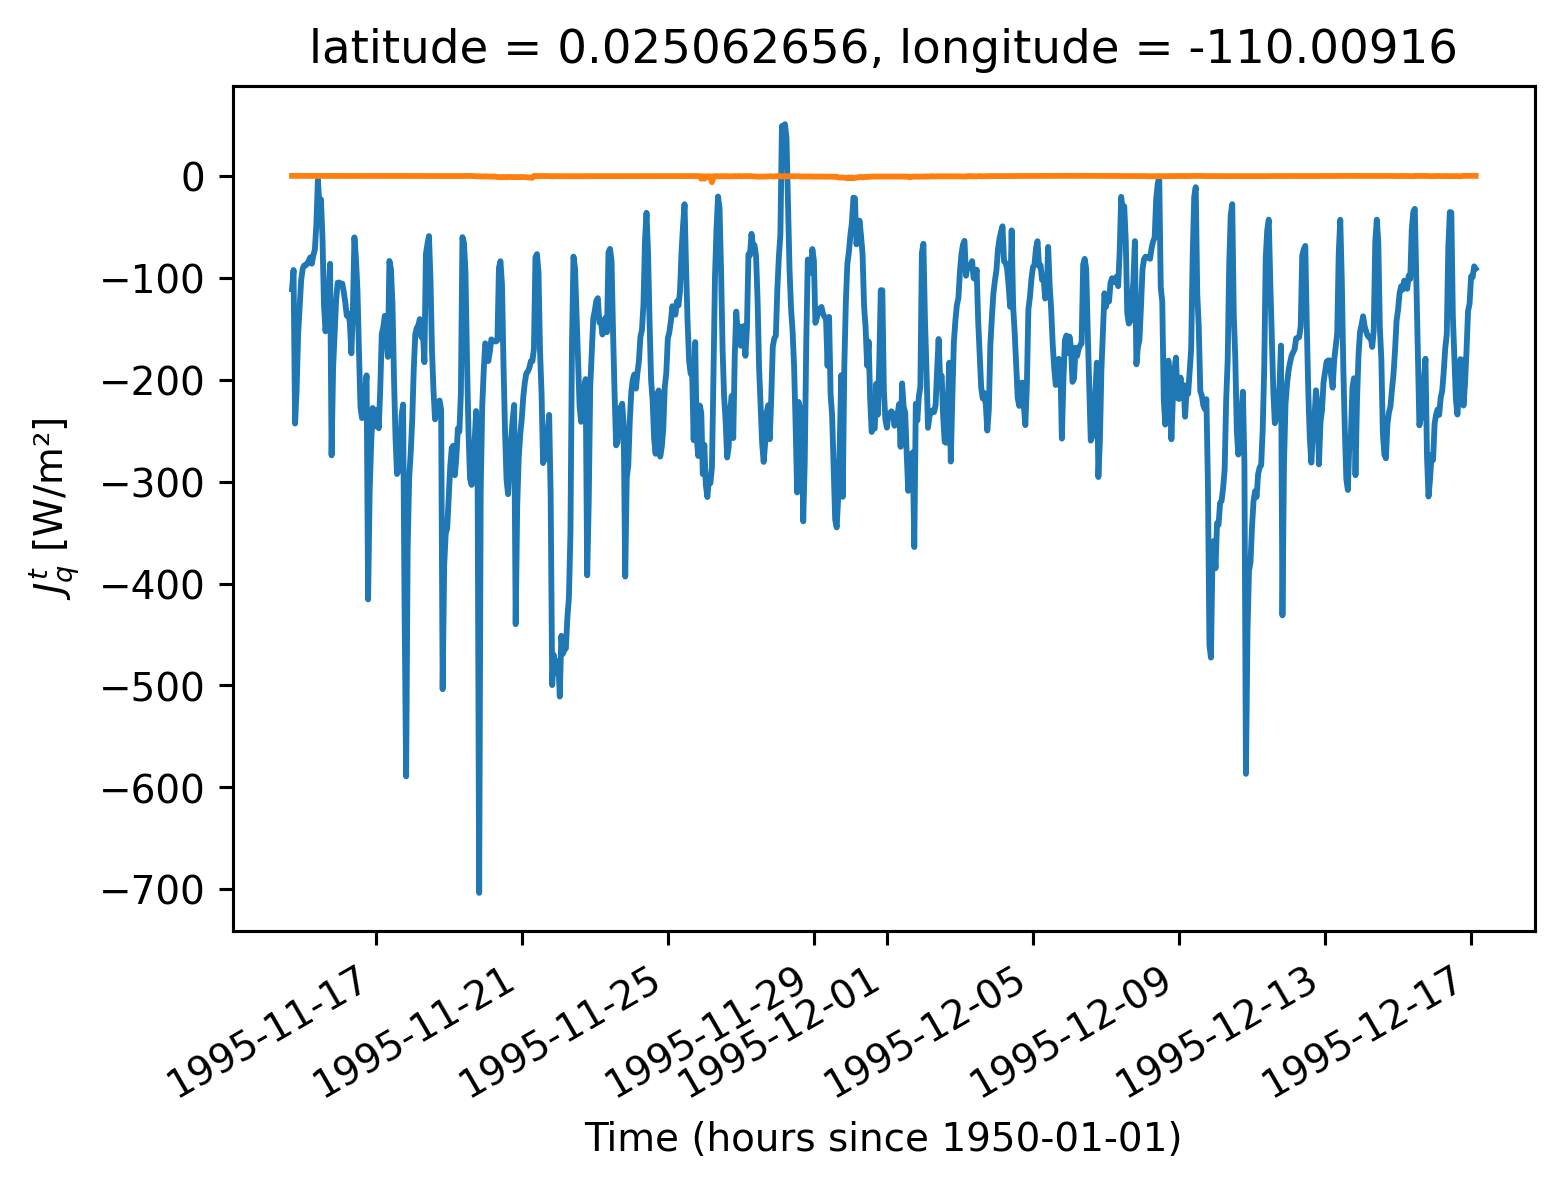

In [ ]:
subset.Jq.sel(depth=subset.mld).plot()
# subset.Jq.sel(depth = subset.dcl_base).plot()
subset.Jq.sel(depth=subset.eucmax).plot()

In [ ]:
sections["Jq_mld"] = sections.Jq.sel(depth=sections.mld)

In [ ]:
sections["Jq_mld"].to_netcdf("Jq_mld_sections.nc")

In [ ]:
sections["Jq_mld"].groupby(sections.enso).mean("time").plot(
    hue="enso", col="longitude", y="latitude"
)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
sections["Jq_mld"].load()

<xarray.DataArray 'Jq_mld' (time: 174000, longitude: 4, latitude: 37)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-1.03868298e+02, -9.28047124e+01, -9.99855702e+01, ...,
         -9.77457590e-03, -5.46678154e-03, -1.31514762e-02],
        [-1.00227533e+02, -1.11465126e+02, -1.13720828e+02, ...,
          2.00975608e-02,  3.01864413e-03,  6.58229011e-03]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-1.35672958e+02, -1.31546214e+02, -2.72644760e+02, ...,
         -1.07197526e+01, -4.62216833e+00, -1.57760598e-02],
        [-1.38687687e+02, -2.02954585e+02, -2.14228750e+02, ...,
          3.73455863e-02,  2.04356325e-02,  3.12642052e-02]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [-1.35402024e+02, -1.63813413e+02, -1.59360881e+02, ...,
         -6.39950970e+01, -5.33501704e+01, -6.75277379e+01]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-1.81391421e+02, -2.11108676e+02, -1.70734973e+02, ...,
         -1.60332500e+00, -2.67643897e+02, -2.43871351e+02],
        [-4.73042316e-01, -3.66597133e+02, -3.58837630e+02, ...,
         -9.48874752e+01, -7.65177667e+01, -8.04016605e+01]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [-4.74883680e+02, -3.78872528e+02,  1.76388468e-01, ...,
         -7.78753898e+00, -1.49216702e+02, -8.76803926e+01],
        [-6.13561940e+01, -1.10279850e+02, -1.28682563e+02, ...,
         -5.74036643e+01, -5.34922762e+01, -4.18560529e+01]]])
Coordinates:
  * longitude  (longitude) float64 -155.0 -140.0 -125.0 -110.0
  * latitude   (latitude) float64 -3.025 -2.775 -2.525 ... 5.475 5.725 5.975
  * time       (time) datetime64[ns] 1998-12-31T18:00:00 ... 2018-11-06T17:00:00

In [ ]:
plt.figure()
plt.plot(sections.time, sections.enso)

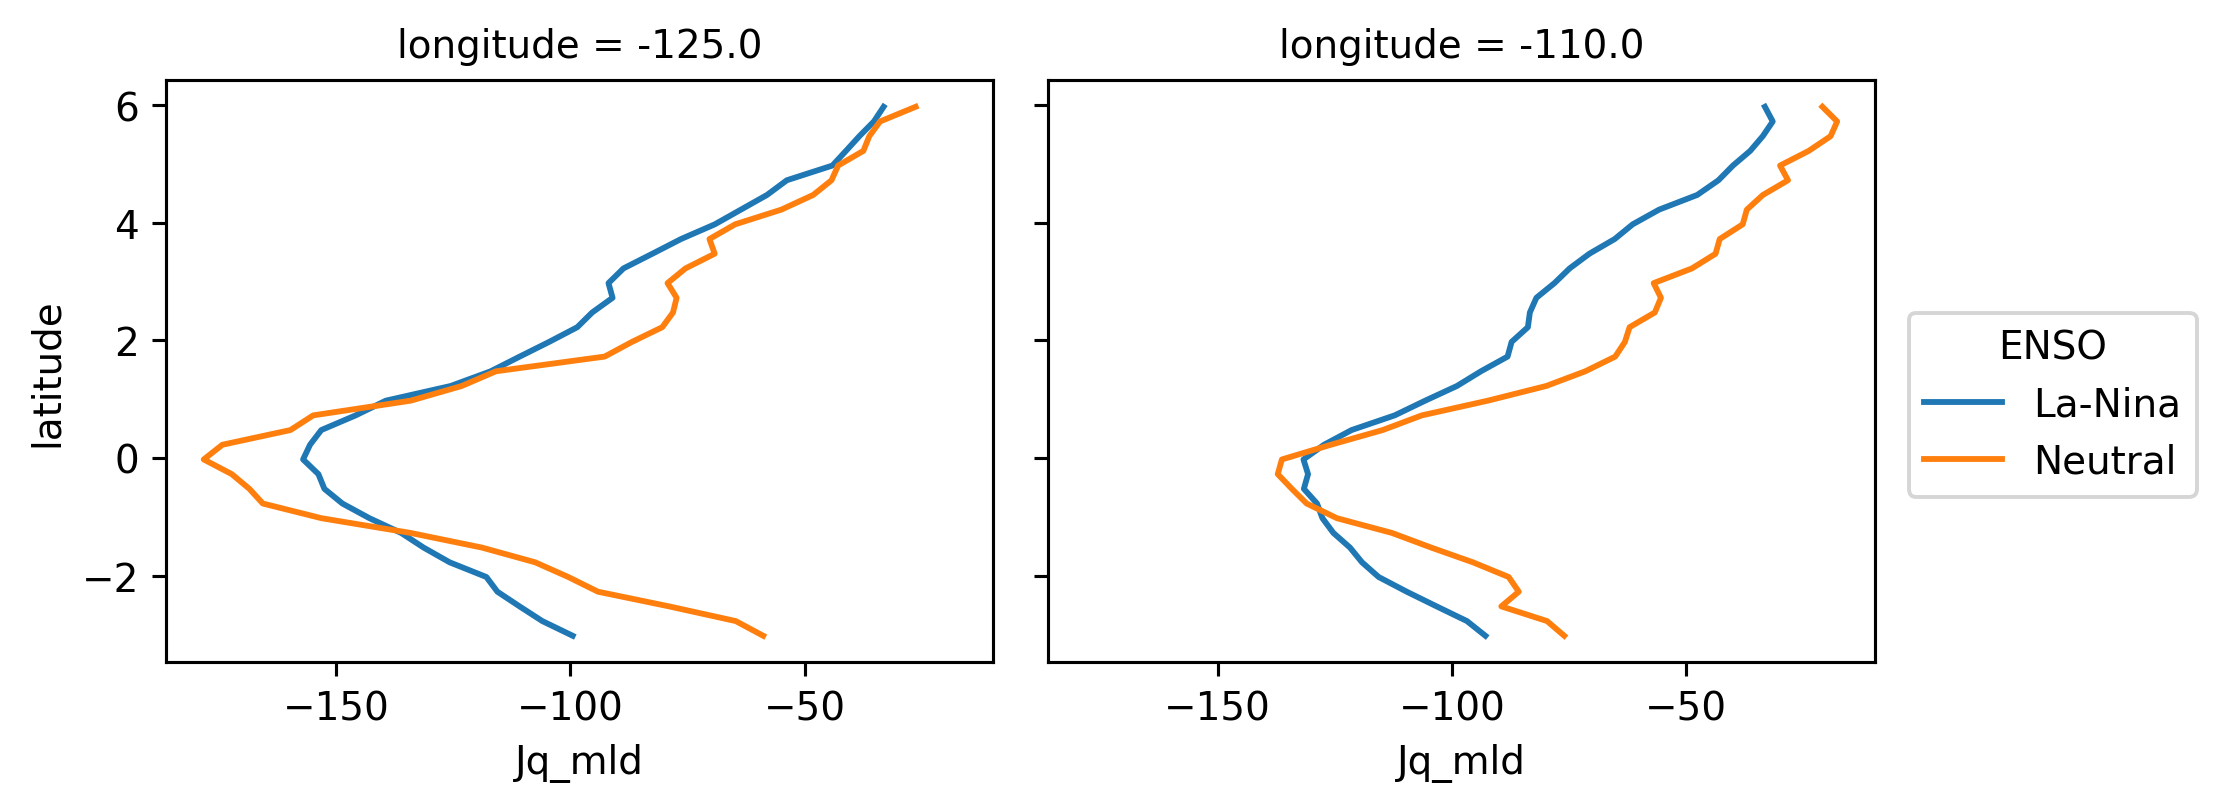

In [ ]:
(
    sections.Jq_mld.sel(longitude=[-125, -110], method="nearest")
    .groupby(enso)
    .mean("time")
    .plot(y="latitude", col="longitude", hue="ENSO")
)

In [ ]:
sections.dcl_Jq.load()

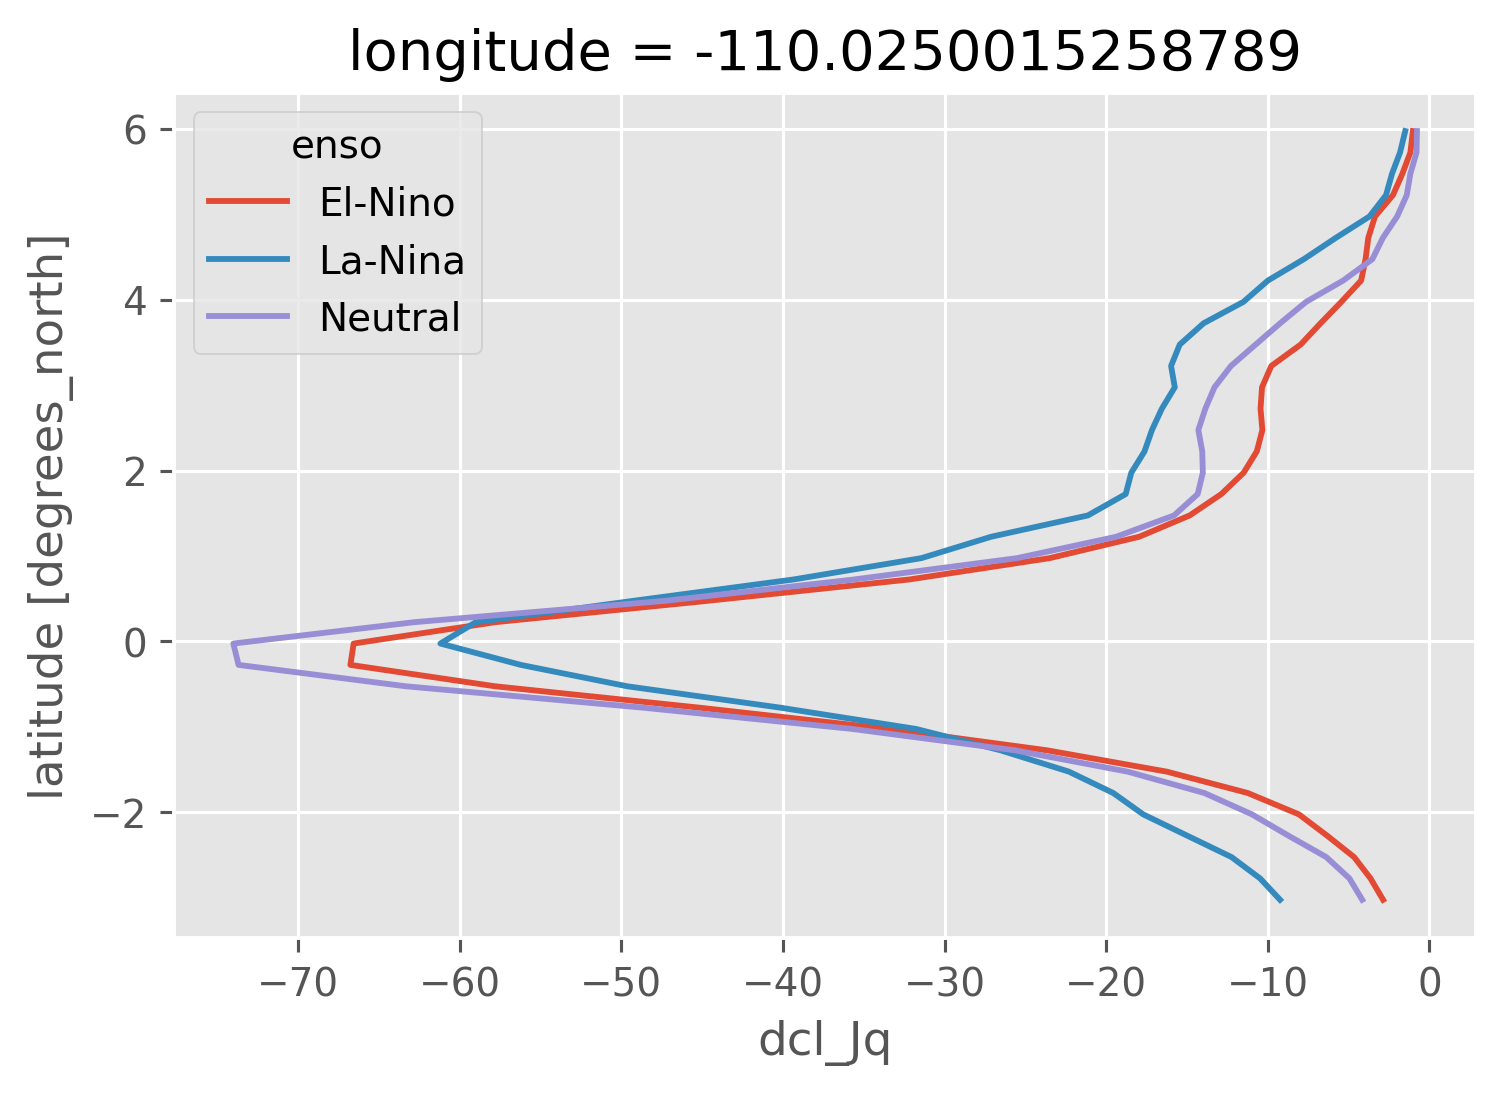

In [ ]:
sections["dcl_Jq"].groupby(sections.enso).mean("time").sel(
    longitude=-110, method="nearest"
).plot(hue="enso", y="latitude")